In [1]:
import re
import json
import os
import sys

parent_path = os.path.abspath('..')
sys.path.append(parent_path)
parent_path = os.path.abspath('../../')
sys.path.append(parent_path)
parent_path = os.path.abspath('../../../')
sys.path.append(parent_path)

from core.ShoreNet.conf import get_data_path

DATA_PATH = get_data_path()

# load .env file
project_path = os.path.abspath('../../')
dotenv_path = os.path.join(project_path, 'secret', '.env')

from dotenv import load_dotenv
load_dotenv(dotenv_path)

print(os.getenv("SISI_DB_TYPE"))

# load project variables
from core.ShoreNet.definitions.variables import VariablesManager

var = VariablesManager()
print(var.data_path)


mysql
D:\data\sisi\


In [2]:
# load dock polygons
from core.ShoreNet.events.dock import get_dock_polygon

dock_polygon_list = get_dock_polygon(var.engine)
print(len(dock_polygon_list))

Dock polygon count: 1518
1518


# 1 Process Sail Events

## 1.1 Cleaning (DBSCAN):

1. Load whole events from SQL database
2. Clean events with DBSCAN, parameter is {radius: 200m, cluster_min_count: 30}
3. Filter noise cluster
4. Further filter: If there are less 20 ships and the count of events less than 60, the cluster will also be recognized as noise cluster.
5. After the double filter, we get the cleaned events dataframe.

In [6]:
import pandas as pd

from sqlalchemy import text

# count all sail logging
stop_event_query = f"""
SELECT 
    mmsi, 
    Begin_time as begin_time, End_time as end_time, end_time - begin_time as duration, 
    lng, lat, Point_num as point_num, Event_categories, coal_dock_id
FROM 
    sisi.factor_stop_events t
WHERE
    t.avgSpeed < 1
"""

# TODO: finish the static query
coal_static_query = f"""
SELECT
    
"""

events_df = pd.read_sql(
    sql=text(stop_event_query), con=var.engine
)

statics_df = None


(1202751, 9)
(942648, 9)
all coal dataframe shape:  (942648, 9)
with poygon coal dataframe shape:  (0, 9)
all coal dataframe contains: 34108 ships
polygon coal dataframe contains: 0 ships
Event with polygon percentage : 0.0 %
cluster count describe: 
count      2341.000000
mean        402.668945
std        4072.942320
min          11.000000
25%          45.000000
50%          78.000000
75%         177.000000
max      167988.000000
Name: count, dtype: float64


In [ ]:
all_coal_df = pd.read_sql(
    sql=text(count_all_coal_query), con=mysql_engine
)
print(all_coal_df.shape)
all_coal_df = all_coal_df.loc[(all_coal_df['duration'] > 1800) &
                              (all_coal_df['duration'] < 7 * 86400) &
                              (all_coal_df['mmsi'].isin(coal_mmsi_list))]
print(all_coal_df.shape)

with_polygon_coal_df = all_coal_df.loc[~all_coal_df['coal_dock_id'].isna()]

print("all coal dataframe shape: ", all_coal_df.shape)
print("with poygon coal dataframe shape: ", with_polygon_coal_df.shape)
print(f"all coal dataframe contains: {all_coal_df['mmsi'].nunique()} ships")
print(f"polygon coal dataframe contains: {with_polygon_coal_df['mmsi'].nunique()} ships")
print(f"Event with polygon percentage : {100 * with_polygon_coal_df.shape[0] / all_coal_df.shape[0]} %")

In [ ]:
## dbscan
# dbscan all coal df, filter noise cluster, then check the percentage.
from sklearn.cluster import DBSCAN

# dbscan all_coal_df
coords = all_coal_df[['lng', 'lat']].values

kms_per_radian = 6371.0088
epsilon = 0.2 / kms_per_radian

# DBSCAN clustering
db = DBSCAN(eps=epsilon, min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# Add cluster labels to the DataFrame
all_coal_df['cluster'] = db.labels_

cluster_counts = all_coal_df['cluster'].value_counts()

print("cluster count describe: ")
print(cluster_counts.describe())

# calculate the percentage
all_coal_df = all_coal_df.loc[all_coal_df['cluster']!=-1]

## 1.2 Calculate the percentage of events in the polygon

In [3]:
cleaned_cluster_id_list = []
for cluster_id, group in all_coal_df.groupby('cluster'):
    # the condition of a events_cluster, must be:
    # 1. ship unique counts > 20
    # 2. group size > 2 * dbscan_radius
    if (group['mmsi'].nunique() > 200) & (group.shape[0] > 400):
        cleaned_cluster_id_list.append(cluster_id)
print(f"events cluster count : {len(cleaned_cluster_id_list)}")
cleaned_coal_df = all_coal_df.loc[all_coal_df['cluster'].isin(cleaned_cluster_id_list)]
with_polygon_dbscan_df = cleaned_coal_df.loc[~cleaned_coal_df['coal_dock_id'].isna()]
without_polygon_dbscan_df = cleaned_coal_df.loc[cleaned_coal_df['coal_dock_id'].isna()]
print(with_polygon_dbscan_df.shape, without_polygon_dbscan_df.shape, cleaned_coal_df.shape)
print(f"Event with polygon percentage is {100 * with_polygon_dbscan_df.shape[0] / cleaned_coal_df.shape[0]} %")

NameError: name 'all_coal_df' is not defined

## 1.3 plot the events without polygon on map

In [5]:
# plot without polygon events
def generate_plot_hull(df, cluster_name):
    plot_row_list = []
    hull_df_list = []
    for coal_dock_id, group in df.groupby(cluster_name):
        _row = group.iloc[0, :]
        # print(_row)
        _d = {'cluster': _row[cluster_name], 'lng': _row['lng'], 'lat': _row['lat'], 'size': group.shape[0]}
        plot_row_list.append(_d)
    
        # get hull data
        num_rows = group.shape[0]
        num_select = int(num_rows * 1.0)
    
        # Randomly select row indices
        selected_indices = np.random.choice(num_rows, num_select, replace=False)
        hull_df_list.append(group.iloc[selected_indices, :])
    plot_df = pd.DataFrame(plot_row_list)
    hull_df = pd.concat(hull_df_list, ignore_index=True)
    hull_df.loc[:, 'mmsi'] = hull_df['mmsi'].astype(str)
    return plot_df, hull_df


def plot_on_map(plot_df, hull_df, cluster_name):
    import plotly.express as px
    import plotly.graph_objects as go
    from scipy.spatial import ConvexHull

    fig = go.Figure()

    # Create a scatter mapbox plot with clusters
    fig = px.scatter_mapbox(
        plot_df,
        lat="lat",
        lon="lng",
        color=cluster_name,
        size="size",
        hover_name=cluster_name,
        hover_data={"size": True, "lat": True, "lng": True},
        title="Clusters on Map",
        color_continuous_scale=px.colors.cyclical.IceFire,
        zoom=5,
        height=600
    )
    
    # Calculate and add the convex hull for each cluster
    unique_clusters = hull_df[cluster_name].unique()
    
    for cluster in unique_clusters:
        if cluster == -1:  # Skip noise points
            continue
        cluster_points = hull_df[hull_df[cluster_name] == cluster][['lng', 'lat']].values
    
        if len(cluster_points) > 2:  # Convex hull requires at least 3 points
            try:
                hull = ConvexHull(cluster_points)
                hull_points = np.append(hull.vertices, hull.vertices[0])  # Append the first point to close the hull
                fig.add_trace(go.Scattermapbox(
                    lon=cluster_points[hull_points, 0],
                    lat=cluster_points[hull_points, 1],
                    mode='lines',
                    fill='toself',
                    fillcolor='rgba(0, 0, 255, 0.1)',  # Semi-transparent fill color
                    line=dict(color='blue'),
                    name=f'Cluster {cluster} Hull'
                ))
            except:
                print(f"cluster_id : {cluster} hull failed.")
    
    # Set the map style and layout
    fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_center={"lat": plot_df["lat"].mean(), "lon": plot_df["lng"].mean()},
        margin={"r":0,"t":0,"l":0,"b":0},
        height=700, width=1200
    )
    
    fig.write_html(r'C:\Users\qiu\IdeaProjects\SISI\core\ShoreNet\notebooks\html\new_tmp.html')
    # fig.show()

plot_df, hull_df = generate_plot_hull(without_polygon_dbscan_df, 'cluster')
print(plot_df.shape, hull_df.shape)
# print(plot_df.describe())

tmp_plot_df = plot_df.loc[plot_df['size'] > 1500]
tmp_hull_df = hull_df.loc[hull_df['cluster'].isin(tmp_plot_df['cluster'])]
print(tmp_plot_df.head())
print(tmp_plot_df.shape, tmp_hull_df.shape)
print(tmp_plot_df.describe())

plot_on_map(tmp_plot_df, tmp_hull_df, 'cluster')

(211, 4) (242335, 10)
   cluster         lng        lat   size
0        0  108.316467  21.614716  15464
3        5  118.013763  38.924267   3231
4        9  122.200119  29.947166   2254
5       10  121.723198  29.960482   4958
6       11  120.239563  36.028030   3400
(41, 4) (136514, 10)
          cluster         lng        lat          size
count   41.000000   41.000000  41.000000     41.000000
mean   163.097561  119.156777  30.706975   3329.609756
std    154.809206    3.654835   3.592562   2475.587464
min      0.000000  108.316467  21.614716   1520.000000
25%     47.000000  118.863243  29.963289   1769.000000
50%    139.000000  120.371597  31.702299   2760.000000
75%    199.000000  121.259743  32.036201   3691.000000
max    758.000000  122.249130  38.924267  15464.000000


# 2 Statistics

## 2.1 Generate Depart & Destination record

In [18]:
with_polygon_dbscan_df = with_polygon_dbscan_df.loc[with_polygon_dbscan_df['Event_categories']!='record_poly']
with_polygon_dbscan_df = with_polygon_dbscan_df.loc[with_polygon_dbscan_df['mmsi'] > 100000000]
cleaned_with_polygon_df = pd.merge(
    left=with_polygon_dbscan_df,
    right=dock_df.loc[:, ['Id', 'Name', 'Province', 'Distruct', 'p-d']],
    how='left',
    left_on='coal_dock_id',
    right_on='Id'
)

del cleaned_with_polygon_df['Id']
del cleaned_with_polygon_df['point_num']

def generate_depart_dest(df, dim_column, next_dim_column):
    records_list = []
    gdf = df.groupby('mmsi')
    group_n = len(gdf)
    n = 1
    for mmsi, group in gdf:
        print(f"\r{n} / {group_n}", end='')
        group.sort_values('begin_time', inplace=True)
        group.loc[:, 'next_polygon_id'] = group['coal_dock_id'].shift(-1)
        group.loc[:, 'next_name'] = group['Name'].shift(-1)
        group.loc[:, 'next_p-d'] = group['p-d'].shift(-1)
        group.loc[:, 'next_province'] = group['Province'].shift(-1)
        group.loc[:, 'next_polygon_arrive_time'] = group['begin_time'].shift(-1)
        group.loc[:, 'next_polygon_lng'] = group['lng'].shift(-1)
        group.loc[:, 'next_polygon_lat'] = group['lat'].shift(-1)
        group.loc[:, 'next_polygon_arrive_time'] = group['begin_time'].shift(-1)
        n += 1
        
        for _, row in group.iterrows():
            if isinstance(row[next_dim_column], float) or isinstance(row[dim_column], float):
                continue
                
            if (row[dim_column] != row[next_dim_column]) & (not row[next_dim_column] is None):
                stop_duration = (row['end_time'] - row['begin_time']) / 86400
                sail_duration = (row['next_polygon_arrive_time'] - row['end_time']) / 86400
                records_list.append([
                    mmsi, row[dim_column], row['lng'], row['lat'],
                    row[next_dim_column], row['next_polygon_lng'], row['next_polygon_lat'],
                    float(f"{sail_duration:.2f}")
                ])
    
    records_df = pd.DataFrame(records_list, columns=['mmsi', 'depart_dim', 'depart_lng', 'depart_lat', 
                                                     'dest_dim', 'dest_lng', 'dest_lat', 'sail_duration'])
    return records_df

dd_df = generate_depart_dest(cleaned_with_polygon_df, 'Province', 'next_province')
dd_df

28293 / 28293

,mmsi,depart_dim,depart_lng,depart_lat,dest_dim,dest_lng,dest_lat,sail_duration
0,100000214,浙江省,122.445503,30.745016,河北省,118.451469,39.012524,211.98
1,100000214,河北省,118.451469,39.012524,浙江省,122.446777,30.752501,54.02
2,104000019,浙江省,122.263649,29.948299,河北省,118.485519,38.943813,100.87
3,110000011,河北省,118.457764,39.018650,天津市,117.717384,38.974518,4.02
4,110000015,河北省,118.457321,39.018616,天津市,117.717018,38.974602,11.45
...,...,...,...,...,...,...,...,...
48497,920101119,天津市,117.722153,38.959816,河北省,117.878464,38.315815,0.87
48498,920101119,河北省,117.878464,38.315815,天津市,117.722168,38.959816,1.66
48499,994126047,河北省,117.887512,38.323002,天津市,117.810577,38.972916,188.89
48500,994126047,天津市,117.810577,38.972916,河北省,117.887512,38.323002,72.38


In [19]:
dd_df = dd_df.loc[dd_df['sail_duration'] > 0]
dd_df.describe()

,mmsi,depart_lng,depart_lat,dest_lng,dest_lat,sail_duration
count,4.849300e+04,48493.000000,48493.000000,48493.000000,48493.000000,48493.000000
mean,4.173932e+08,118.458691,31.555524,118.512417,31.561257,21.995904
std,4.022748e+07,2.759069,1.866416,2.715407,1.833525,31.423959
min,1.000002e+08,108.326332,21.534166,108.317780,21.533966,0.010000
25%,4.137990e+08,117.233711,30.507000,117.238297,30.507000,5.680000
50%,4.138324e+08,119.551598,31.673500,119.555534,31.671301,11.570000
75%,4.138661e+08,120.361298,32.033054,120.340469,32.039902,25.440000
max,1.000996e+09,122.458961,39.936901,122.458961,39.935665,352.970000


In [59]:
dd_df.to_csv(rf"C:\Users\qiu\OneDrive\文档\SISI\3沿海干散货研究\data\coal_log_data\dd_df.csv", index=False, encoding='utf-8-sig')

## 2.2 Cargo List

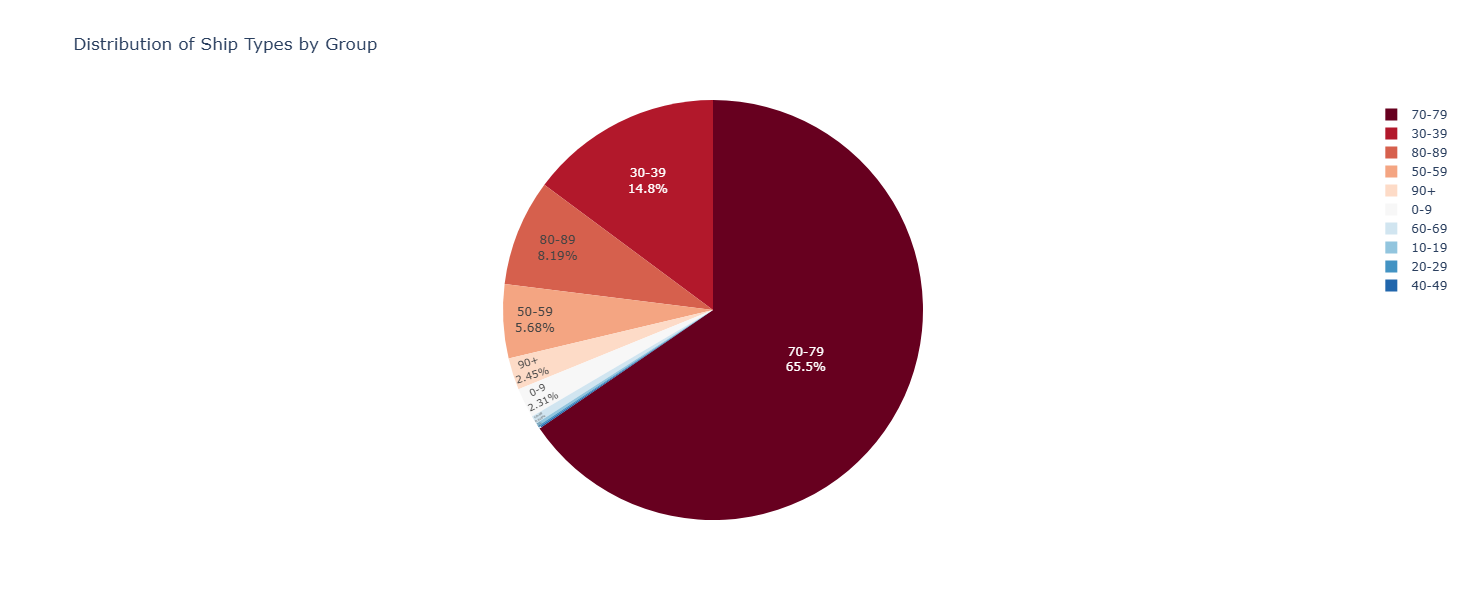

In [20]:
ship_data = pd.read_csv(rf"C:\Users\qiu\OneDrive\文档\SISI\3沿海干散货研究\data\sisi_ShoreNet_dim_ships_static.csv")

# Define bins for ship types
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, float('inf')]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

# Bin the ship_type data
ship_data['ship_type_group'] = pd.cut(ship_data['ship_type'], bins=bins, labels=labels, right=False)

# Calculate the count for each group
group_counts = ship_data['ship_type_group'].value_counts().sort_index()

# Prepare data for pie chart
pie_data = pd.DataFrame({'ship_type_group': group_counts.index, 'count': group_counts.values})

# Create a pie chart using Plotly
fig = px.pie(
    pie_data,
    names='ship_type_group',
    values='count',
    title='Distribution of Ship Types by Group',
    color_discrete_sequence=px.colors.sequential.RdBu
)

# Add annotations for each group
fig.update_traces(textposition='inside', textinfo='percent+label')

# Adjust layout
fig.update_layout(
    height=600,
    width=1000
)

fig.show()

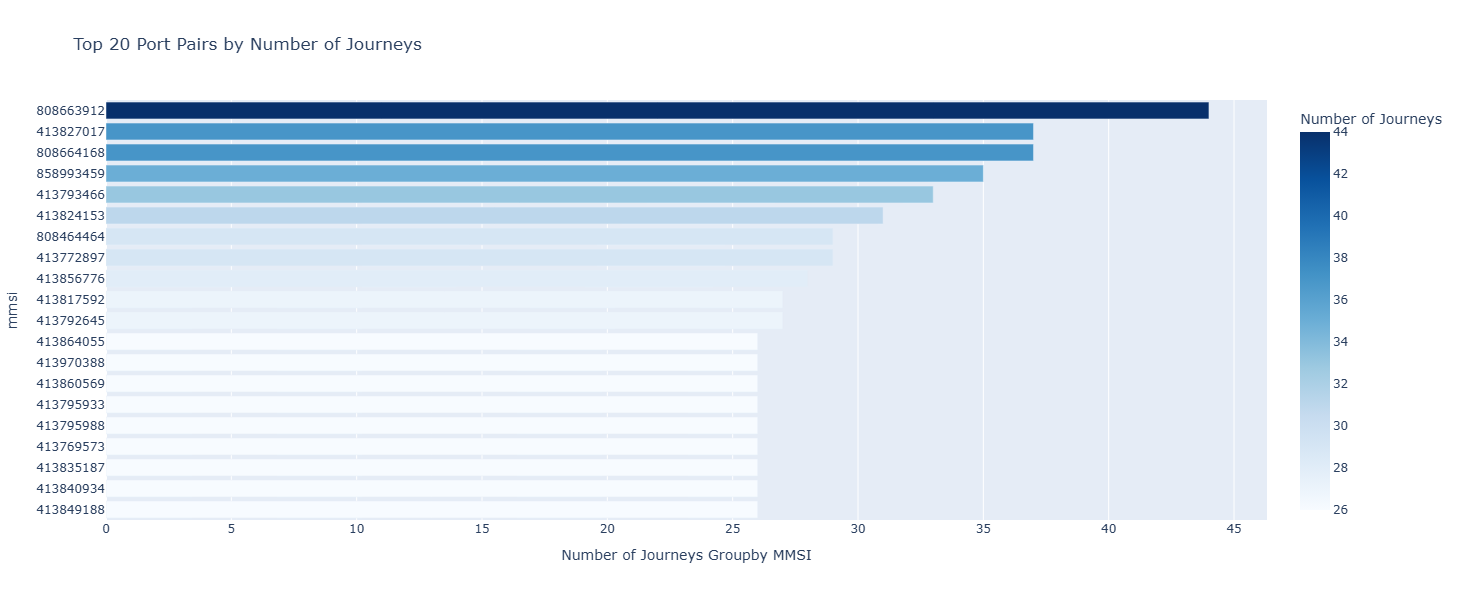

In [21]:
import pandas as pd
import plotly.express as px

# Assuming dd_df is your DataFrame
# Calculate the top port pairs (depart, dest) count
top_port_pairs = dd_df.groupby(['mmsi']).size().reset_index(name='count')
top_port_pairs = top_port_pairs.sort_values(by='count', ascending=False).head(20)

# Prepare labels for the bar chart
top_port_pairs['port_pair'] = top_port_pairs.apply(lambda x: f"{x['mmsi']}", axis=1)

# Use Plotly to create a bar chart
fig = px.bar(
    top_port_pairs,
    x='count',
    y='port_pair',
    orientation='h',
    labels={'count': 'Number of Journeys', 'mmsi': 'mmsi'},
    title='Top 20 Port Pairs by Number of Journeys',
    color='count',
    color_continuous_scale='Blues'
)

# Adjust layout
fig.update_layout(
    xaxis_title='Number of Journeys Groupby MMSI',
    yaxis_title='mmsi',
    yaxis={'categoryorder': 'total ascending'},
    height=600,
    width=1000
)

# Show the chart
fig.show()

In [6]:
static_df = pd.read_csv(r"/statics\coal_mmsi_v1_init_static.csv")
print(static_df.shape)

(85353, 17)


In [7]:
static_df = pd.read_csv(r"/statics\coal_mmsi_v1_init_static.csv")
static_df = static_df.loc[:, ['mmsi', 'shipname', 'shiptype', 'length', 'breadth', 'receivetime']]
static_df.sort_values(by='receivetime', inplace=True)
static_df.reset_index(inplace=True)
print(static_df.shape)

"""
There are error data in static_data. 
This function is aim to filter error data.

Valid Data Request:
0. length and breadth are numerical.
1. contains length and breadth
2. length ∈ (0, +∞)
3. breadth ∈ (0, +∞)
"""
static_df = static_df.loc[static_df['length']!='""']
print(static_df.shape)
static_df = static_df.loc[static_df['breadth']!='""']
print(static_df.shape)
static_df = static_df.loc[static_df['shiptype']!='""']
print(static_df.shape)

static_df.loc[:, 'length'] = static_df['length'].astype(float)
static_df.loc[:, 'breadth'] = static_df['breadth'].astype(float)
static_df.loc[:, 'shiptype'] = static_df['shiptype'].astype(float)

static_df = static_df.loc[static_df['length'] > 0]
static_df = static_df.loc[static_df['breadth'] > 0]
static_df.loc[:, 'length_breadth_ratio'] = static_df.apply(lambda row: row['length'] / row['breadth'], axis=1)
# print(static_df.describe())
# print(np.percentile(static_df['length_breadth_ratio'], 5))  # equals to 3
# print(np.percentile(static_df['length_breadth_ratio'], 95))  # equals to 7.1
static_df = static_df.loc[(static_df['length_breadth_ratio'] > 3) & 
                          (static_df['length_breadth_ratio'] < 7.1)]
print(static_df.shape)

def filter_static(df):
    pass

static_info_list = []

for mmsi, group in static_df.groupby('mmsi'):
    # # print(group.describe())
    # for _, row in group.iterrows():
    #     # check length
    #     if isinstance(row['length'], str):
    #         continue
    #     else:
    #         if isinstance(row['length'], float):
    #             if ~np.isnan(row['length']):
    #                 print(row['length'])
    mmsi_info = {'mmsi': mmsi}
    length_var = np.var(group['length'])
    breadth_var = np.var(group['breadth'])
    mmsi_info['length_var'] = length_var
    mmsi_info['breadth_var'] = breadth_var
    static_info_list.append(mmsi_info)
    
static_statistical_df = pd.DataFrame(static_info_list)
print(np.percentile(static_statistical_df['length_var'], 90))  # equals to 0
print(np.percentile(static_statistical_df['breadth_var'], 90))  # equals to 0
static_statistical_df = static_statistical_df.loc[(static_statistical_df['length_var'] == 0) & 
                                                  (static_statistical_df['breadth_var'] == 0)]
static_statistical_df.describe()

static_df = static_df.loc[static_df['mmsi'].isin(static_statistical_df['mmsi'])]
static_df.drop_duplicates(subset=['mmsi'], keep='last', inplace=True)
print(static_df.shape)

(85353, 7)
(70697, 7)
(70597, 7)
(70263, 7)
(40748, 8)
0.0
0.0
(13297, 8)


In [16]:
static_load_df = pd.read_csv(r"/statics\coal_mmsi_v1_init_with_load.csv")
static_load_df = static_load_df.loc[~static_load_df['DWT'].isna()]
static_load_df.loc[:, 'dwt_int'] = static_load_df['DWT'].map(lambda x: x.replace(',', '')).astype(int)
print(static_load_df.loc[static_load_df['mmsi']==412667000])
static_load_df.describe()

Empty DataFrame
Columns: [DWT, mmsi, dwt_int]
Index: []


,mmsi,dwt_int
count,3.263000e+03,3263.000000
mean,4.327290e+08,57956.184493
std,8.865306e+07,60396.747859
min,2.055540e+08,0.000000
25%,4.127765e+08,9450.000000
50%,4.137909e+08,50244.000000
75%,4.147825e+08,73700.000000
max,1.000000e+09,399300.000000


In [98]:
mdf = pd.merge(
    left=static_df,
    right=static_teu_df,
    on='mmsi',
    how='inner'
)
mdf

,index,mmsi,shipname,shiptype,length,breadth,receivetime,length_breadth_ratio,TEU
0,80986,256763000,ISTANBUL EXPRESS,74.0,300.0,48.0,1.709227e+09,6.250000,9040
1,41899,636021251,MSC ADONIS,71.0,300.0,48.0,1.709228e+09,6.250000,9288
2,25487,574002850,HAIAN TIME,70.0,162.0,26.0,1.709228e+09,6.230769,1032
3,62866,538005308,SAFEEN PRIME,71.0,209.0,30.0,1.709233e+09,6.966667,2500
4,79121,564909000,KOTA HAKIM,70.0,160.0,25.0,1.709238e+09,6.400000,1080
...,...,...,...,...,...,...,...,...,...
151,32720,413842574,HONG CHENG 6899,70.0,74.0,16.0,1.711713e+09,4.625000,97
152,12111,248402000,CMA CGM BKLLINI,71.0,277.0,40.0,1.711739e+09,6.925000,5782
153,28310,574005640,HAIAN CITY,73.0,172.0,27.0,1.711754e+09,6.370370,1577
154,53271,566828000,WANHAI515,70.0,259.0,37.0,1.711890e+09,7.000000,4680


## 2.3 Port Pairs by Province

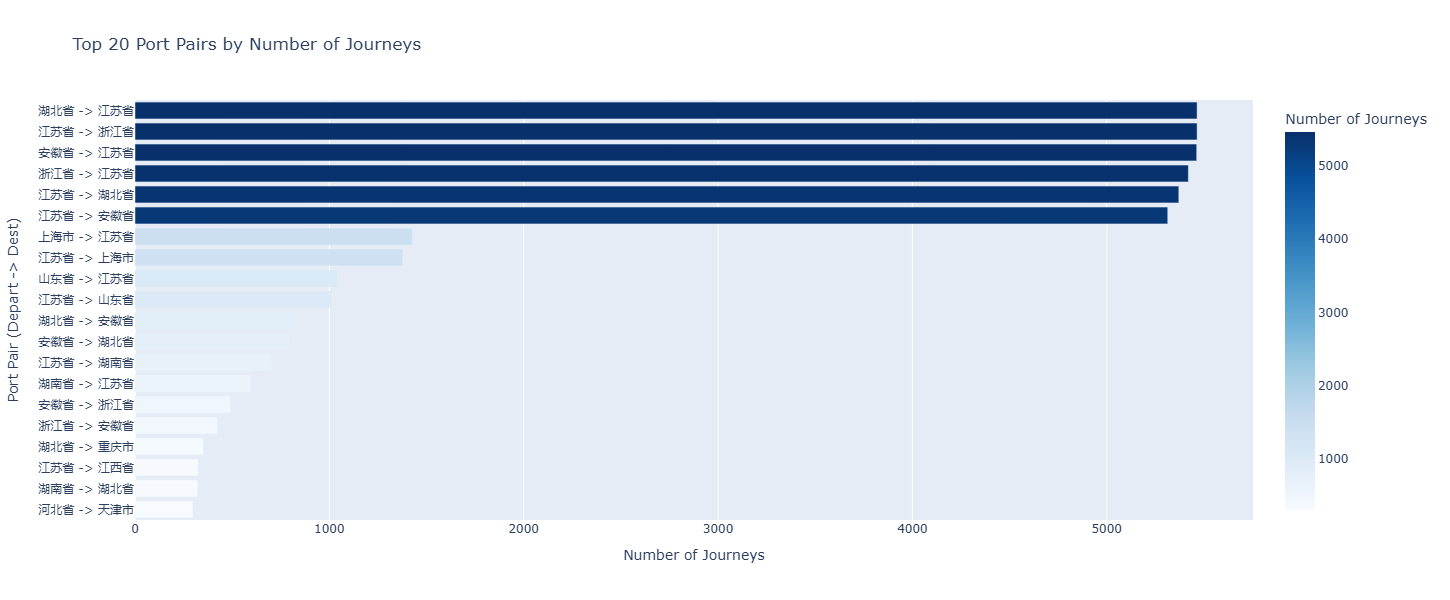

In [22]:
import pandas as pd
import plotly.express as px

# Assuming dd_df is your DataFrame
# Calculate the top port pairs (depart, dest) count
top_port_pairs = dd_df.groupby(['depart_dim', 'dest_dim']).size().reset_index(name='count')
top_port_pairs = top_port_pairs.sort_values(by='count', ascending=False).head(20)

# Prepare labels for the bar chart
top_port_pairs['port_pair'] = top_port_pairs.apply(lambda x: f"{x['depart_dim']} -> {x['dest_dim']}", axis=1)

# Use Plotly to create a bar chart
fig = px.bar(
    top_port_pairs,
    x='count',
    y='port_pair',
    orientation='h',
    labels={'count': 'Number of Journeys', 'port_pair': 'Port Pair (Depart -> Dest)'},
    title='Top 20 Port Pairs by Number of Journeys',
    color='count',
    color_continuous_scale='Blues'
)

# Adjust layout
fig.update_layout(
    xaxis_title='Number of Journeys',
    yaxis_title='Port Pair (Depart -> Dest)',
    yaxis={'categoryorder': 'total ascending'},
    height=600,
    width=1000
)

# Show the chart
fig.show()

In [23]:
import plotly.graph_objects as go
import plotly.express as px

# Calculate the top 20 port pairs (depart, dest) count
top_port_pairs_list = []
for pair, group in dd_df.groupby(['depart_dim', 'dest_dim']):
    _row = group.iloc[0, :]
    top_port_pairs_list.append(
        {
            'depart_dim': pair[0],
            'dest_dim': pair[1],
            'depart_lng': _row['depart_lng'],
            'depart_lat': _row['depart_lat'],
            'dest_lng': _row['dest_lng'],
            'dest_lat': _row['dest_lat'],
            'count': group.shape[0]
        }
    )

# top_port_pairs = dd_df.groupby(['depart_dim', 'dest_dim', 'depart_lng', 'depart_lat', 'dest_lng', 'dest_lat']).size().reset_index(name='count')
top_port_pairs = pd.DataFrame(top_port_pairs_list)
top_port_pairs = top_port_pairs.loc[top_port_pairs['count'] > 10]
top_port_pairs = top_port_pairs.sort_values(by='count', ascending=False).head(50)
print(top_port_pairs.describe())

# Generate unique colors for each port
ports = list(set(top_port_pairs['depart_dim']).union(set(top_port_pairs['dest_dim'])))
print(ports)
colors = px.colors.qualitative.T10[:len(ports)]
print(colors)
port_color_map = {port: colors[0] for i, port in enumerate(ports)}

# Create the figure
fig = go.Figure()

# Add transport flows
for idx, row in top_port_pairs.iterrows():
    fig.add_trace(go.Scattermapbox(
        lon=[row['depart_lng'], row['dest_lng']],
        lat=[row['depart_lat'], row['dest_lat']],
        mode='markers+lines+text',
        marker={'size': 10, 'color': port_color_map[row['depart_dim']]},
        line=dict(width=2, color=port_color_map[row['depart_dim']]),
        text=[row['depart_dim'], row['dest_dim']],
        textposition='top center',
        name=f"{row['depart_dim']} -> {row['dest_dim']}"
    ))

# Set the map configuration
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": dd_df["depart_lat"].mean(), "lon": dd_df["depart_lng"].mean()},
    mapbox=dict(
        zoom=4
    ),
    margin={"r":0,"t":0,"l":0,"b":0},
    showlegend=True,
    width=800,
    height=800,
)

# Add legend
for port, color in port_color_map.items():
    fig.add_trace(go.Scattermapbox(
        lon=[None],
        lat=[None],
        mode='markers',
        marker={'size': 10, 'color': color},
        name=port
    ))

# Show the plot
fig.write_html(r'C:\Users\qiu\IdeaProjects\SISI\core\ShoreNet\notebooks\html\depart_dest_liner.html')
# fig.save()

       depart_lng  depart_lat    dest_lng   dest_lat        count
count   50.000000   50.000000   50.000000  50.000000    50.000000
mean   117.650534   32.059365  118.226995  32.144894   943.160000
std      3.632643    3.199142    3.230636   2.834935  1699.327278
min    108.334030   21.577831  109.514633  29.412016    62.000000
25%    115.345926   29.976125  116.127607  29.969650   112.250000
50%    118.461830   31.186040  118.460609  31.384643   244.500000
75%    120.203789   33.280791  120.821056  32.346478   676.000000
max    122.445503   39.216000  122.446777  39.209015  5465.000000
['湖北省', '广西壮族自治区', '重庆市', '天津市', '湖南省', '上海市', '江西省', '山东省', '浙江省', '安徽省', '河北省', '河南省', '江苏省']
['#4C78A8', '#F58518', '#E45756', '#72B7B2', '#54A24B', '#EECA3B', '#B279A2', '#FF9DA6', '#9D755D', '#BAB0AC']


count    135833.000000
mean         17.534560
std          27.099961
min           0.010000
25%           2.890000
50%           8.490000
75%          21.130000
max         361.830000
Name: sail_duration, dtype: float64


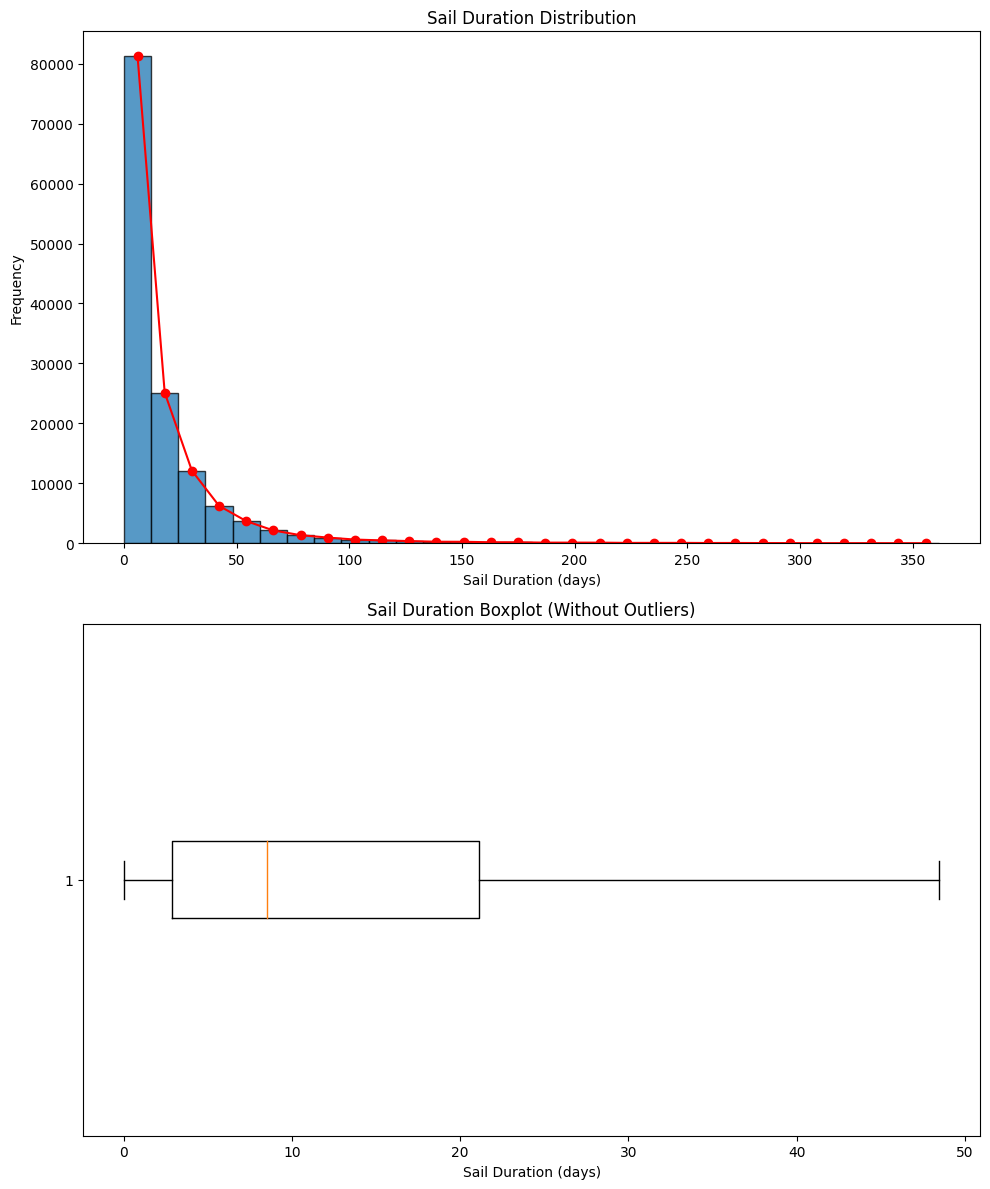

In [71]:
# Plotting Sail Duration Histogram with a Boxplot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Print summary statistics of sail duration
print(dd_df['sail_duration'].describe())

# Histogram
n, bins, patches = ax[0].hist(dd_df['sail_duration'], bins=30, alpha=0.75, edgecolor='black')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
ax[0].plot(bin_centers, n, '-o', color='red')
ax[0].set_title('Sail Duration Distribution')
ax[0].set_xlabel('Sail Duration (days)')
ax[0].set_ylabel('Frequency')

# Boxplot without outliers
ax[1].boxplot(dd_df['sail_duration'], vert=False, showfliers=False)
ax[1].set_title('Sail Duration Boxplot (Without Outliers)')
ax[1].set_xlabel('Sail Duration (days)')

plt.tight_layout()
plt.show()

In [5]:
## dbscan without_polygon_dbscan_df
from sklearn.cluster import DBSCAN

from core.ShoreNet.utils.polygon import hull_points_to_sql


coords = without_polygon_dbscan_df[['lng', 'lat']].values

kms_per_radian = 6371.0088
epsilon = 0.2 / kms_per_radian

# DBSCAN clustering
db = DBSCAN(eps=epsilon, min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# Add cluster labels to the DataFrame
without_polygon_dbscan_df['cluster'] = db.labels_

cluster_counts = without_polygon_dbscan_df['cluster'].value_counts()

print("cluster count describe: ")
print(cluster_counts.describe())

c_dict_list = []
for cluster_id, group in without_polygon_dbscan_df.groupby('cluster'):
    first_row = group.iloc[0, :]
    if (group.shape[0] > 100) & (group['mmsi'].nunique() > 30):
        c_dict = {'cluster': cluster_id, 'size': group.shape[0], 'lng': first_row['lng'], 'lat': first_row['lat']}
        c_dict_list.append(c_dict)
without_polgon_dbscan_merged_df = pd.DataFrame(c_dict_list)
without_polgon_dbscan_merged_df.describe()

cluster count describe: 
count      240.000000
mean       583.983333
std       2695.126572
min         30.000000
25%         61.750000
50%        106.000000
75%        204.500000
max      28469.000000
Name: count, dtype: float64


C:\Users\qiu\AppData\Local\Temp\ipykernel_32748\1505934784.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  without_polygon_dbscan_df['cluster'] = db.labels_


,cluster,size,lng,lat
count,89.000000,89.000000,89.000000,89.000000
mean,75.393258,1411.415730,120.573865,33.440982
std,55.395811,4314.630203,1.779665,3.851279
min,-1.000000,101.000000,113.849403,29.722116
25%,29.000000,148.000000,119.486145,29.961599
50%,60.000000,219.000000,121.479668,31.197100
75%,120.000000,550.000000,122.024452,36.109314
max,208.000000,28469.000000,122.268967,40.747780


In [6]:
hull_points_to_sql(without_polygon_dbscan_df)
print(f"hull save sql server successfully.")

hull save sql server successfully.


In [5]:
all_coal_df.describe()

,mmsi,begin_time,end_time,duration,lng,lat,point_num,coal_dock_id,cluster
count,2.050780e+05,2.050780e+05,2.050780e+05,205078.000000,205078.000000,205078.000000,205078.000000,184251.000000,205078.000000
mean,4.203878e+08,1.689212e+09,1.689272e+09,60797.299076,120.267417,34.007251,121.733804,1035.272590,60.382084
std,7.132258e+07,9.052542e+06,9.055160e+06,85170.036808,1.848635,4.116027,551.086515,543.340794,98.125990
min,1.000001e+08,1.672531e+09,1.672533e+09,1801.000000,106.436119,18.053049,1.000000,3.000000,0.000000
25%,4.123620e+08,1.681458e+09,1.681550e+09,12980.250000,117.945505,29.935717,5.000000,1297.000000,8.000000
50%,4.132730e+08,1.689153e+09,1.689222e+09,35504.500000,120.324699,35.325661,14.000000,1298.000000,13.000000
75%,4.134368e+08,1.697011e+09,1.697082e+09,69397.000000,121.929680,38.952881,40.000000,1317.000000,63.000000
max,9.999338e+08,1.704062e+09,1.704067e+09,604742.000000,125.151146,40.749664,49132.000000,1531.000000,498.000000


In [9]:
all_coal_df.loc[all_coal_df['lat'] < 29].shape, all_coal_df.loc[all_coal_df['lat'] > 29].shape

((1601, 10), (203477, 10))

# Check South China stopping events

In [3]:
# check south china event logs
import os

start_month, end_month = 1, 12
months = [f"2023{x:02}" for x in range(start_month, end_month+1)]
use_fields = [
                 'mmsi', 'Begin_time', 'End_time', 'Begin_lon', 'Begin_lat',
                 'avgSpeed', 'Point_num', 'nowPortName', 'nowDockName', 'nowBerthName', 'Event_categories'
             ]

month_sail_df_list = []
for month in months:
    month_sail_df = pd.read_csv(f"{DATA_PATH}/log_data/{month}_new_sailingv4.csv",
                                skipinitialspace=True, usecols=use_fields)
    month_sail_df.rename(columns={'Begin_lon': 'lng', 'Begin_lat': 'lat'}, inplace=True)
    month_sail_df.loc[:, 'lng'] = month_sail_df['lng'].multiply(0.000001)
    month_sail_df.loc[:, 'lat'] = month_sail_df['lat'].multiply(0.000001)

    month_sail_df = month_sail_df.loc[(month_sail_df['lng'] > 105.5) & (month_sail_df['lng'] < 126) &
                                      (month_sail_df['lat'] > 18) & (month_sail_df['lat'] < 29.7) &  # south china lat
                                      (month_sail_df['avgSpeed'] < 1)]
    month_sail_df_list.append(month_sail_df)
    
sail_df = pd.concat(month_sail_df_list, ignore_index=True)
sail_df

C:\Users\qiu\AppData\Local\Temp\ipykernel_55176\3302991077.py:22: DtypeWarning: Columns (34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  month_sail_df = pd.read_csv(f"{DATA_PATH}/log_data/{month}_new_sailingv4.csv",
C:\Users\qiu\AppData\Local\Temp\ipykernel_55176\3302991077.py:22: DtypeWarning: Columns (34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  month_sail_df = pd.read_csv(f"{DATA_PATH}/log_data/{month}_new_sailingv4.csv",
C:\Users\qiu\AppData\Local\Temp\ipykernel_55176\3302991077.py:22: DtypeWarning: Columns (34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  month_sail_df = pd.read_csv(f"{DATA_PATH}/log_data/{month}_new_sailingv4.csv",
C:\Users\qiu\AppData\Local\Temp\ipykernel_55176\3302991077.py:22: DtypeWarning: Columns (34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  month_sail_df = pd.read_csv(f"{DATA_PATH}/log_data/{month}_new_sailingv4.cs

,mmsi,Begin_time,End_time,lng,lat,Point_num,avgSpeed,nowPortName,nowDockName,nowBerthName,Event_categories
0,0.000000e+00,1.674779e+09,1.674785e+09,121.919650,29.004600,8.0,0.0,shipuanch,-1,-1,low_speed_event
1,0.000000e+00,1.674864e+09,1.674930e+09,121.883800,29.162200,219.0,0.0,shipu,Dongxing Peroleum,-1,low_speed_event
2,1.000000e+00,1.672964e+09,1.672964e+09,119.778831,26.293931,2.0,0.0,lianjianganch,-1,-1,low_speed_event
3,1.000000e+00,1.673741e+09,1.675181e+09,120.283991,22.627266,693.0,0.0,kaohsiung,Penglai Commercial Harbour,-1,low_speed_event
4,2.000000e+00,1.673054e+09,1.673074e+09,108.697981,18.682066,3.0,0.0,NaN,NaN,NaN,low_speed_event
...,...,...,...,...,...,...,...,...,...,...,...
6887765,9.999990e+08,1.701389e+09,1.702944e+09,118.000999,24.429199,126.0,0.0,xiamen,-1,-1,record_poly
6887766,9.999990e+08,1.703030e+09,1.704067e+09,118.000999,24.429199,258.0,0.0,xiamen,-1,-1,record_poly
6887767,1.028074e+09,1.703757e+09,1.703769e+09,118.119202,24.321301,14.0,0.0,xiamen,-1,-1,record_poly
6887768,1.059699e+09,1.701659e+09,1.701670e+09,118.116203,24.324699,14.0,0.0,xiamen,-1,-1,record_poly


In [5]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)


def find_dock(event_row, dock_list):
    """
    calculate the distance between the first point of the event and the first point of the dock polygon.
    """
    from core.ShoreNet.utils.geo import point_poly, get_geodist
    
    # dock_list = get_dock_list()
    # if np.random.randint(0, 100, 1)[0] < 5:
    #     print(f"{month}, {event_row['mmsi']}")

    for polygon in dock_list:
        dst_list = []
        for d_lng, d_lat in polygon['polygon']:
            geodist = get_geodist(event_row['lng'], event_row['lat'], d_lng, d_lat)
            dst_list.append(geodist)
            
        if min(dst_list) < 8:
            if point_poly(event_row['lng'], event_row['lat'], polygon['polygon']):
                return polygon['dock_id']

dock_tag = sail_df.parallel_apply(find_dock, args=(dock_polygon_list, ), axis=1)
sail_df.loc[:, 'coal_dock_id'] = dock_tag

sail_df

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,mmsi,Begin_time,End_time,lng,lat,Point_num,avgSpeed,nowPortName,nowDockName,nowBerthName,Event_categories,coal_dock_id
0,0.000000e+00,1.674779e+09,1.674785e+09,121.919650,29.004600,8.0,0.0,shipuanch,-1,-1,low_speed_event,NaN
1,0.000000e+00,1.674864e+09,1.674930e+09,121.883800,29.162200,219.0,0.0,shipu,Dongxing Peroleum,-1,low_speed_event,NaN
2,1.000000e+00,1.672964e+09,1.672964e+09,119.778831,26.293931,2.0,0.0,lianjianganch,-1,-1,low_speed_event,NaN
3,1.000000e+00,1.673741e+09,1.675181e+09,120.283991,22.627266,693.0,0.0,kaohsiung,Penglai Commercial Harbour,-1,low_speed_event,NaN
4,2.000000e+00,1.673054e+09,1.673074e+09,108.697981,18.682066,3.0,0.0,NaN,NaN,NaN,low_speed_event,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6887765,9.999990e+08,1.701389e+09,1.702944e+09,118.000999,24.429199,126.0,0.0,xiamen,-1,-1,record_poly,NaN
6887766,9.999990e+08,1.703030e+09,1.704067e+09,118.000999,24.429199,258.0,0.0,xiamen,-1,-1,record_poly,NaN
6887767,1.028074e+09,1.703757e+09,1.703769e+09,118.119202,24.321301,14.0,0.0,xiamen,-1,-1,record_poly,NaN
6887768,1.059699e+09,1.701659e+09,1.701670e+09,118.116203,24.324699,14.0,0.0,xiamen,-1,-1,record_poly,NaN


In [7]:
sail_df.to_csv(os.path.join(DATA_PATH, "log_data/2023_sail_events_south_china_with_polygon.csv"), index=False)

In [12]:
sail_df = pd.read_csv(os.path.join(DATA_PATH, "log_data/2023_sail_events_south_china_with_polygon.csv"))
south_china_with_polygon_sail_df = sail_df.loc[~sail_df['coal_dock_id'].isna()]
print(south_china_with_polygon_sail_df.shape)

plot_row_list = []
hull_df_list = []
for coal_dock_id, group in south_china_with_polygon_sail_df.groupby('coal_dock_id'):
    _row = group.iloc[0, :]
    _d = {'coal_dock_id': coal_dock_id, 'lng': _row['lng'], 'lat': _row['lat'], 'size': group.shape[0]}
    plot_row_list.append(_d)

    # get hull data
    num_rows = group.shape[0]
    num_select = int(num_rows * 1.0)

    # Randomly select row indices
    selected_indices = np.random.choice(num_rows, num_select, replace=False)
    hull_df_list.append(group.iloc[selected_indices, :])
    
plot_df = pd.DataFrame(plot_row_list)
hull_df = pd.concat(hull_df_list, ignore_index=True)
hull_df.loc[:, 'mmsi'] = hull_df['mmsi'].astype(str)
print(plot_df.shape, hull_df.shape)
print(plot_df.describe())

C:\Users\qiu\AppData\Local\Temp\ipykernel_55000\2875881167.py:1: DtypeWarning:

Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.



(66040, 12)
(60, 4) (66040, 12)
       coal_dock_id         lng        lat          size
count     60.000000   60.000000  60.000000     60.000000
mean     431.316667  115.728829  24.108670   1100.666667
std      549.204648    4.541632   2.854695   2295.521813
min       33.000000  108.327057  18.233200     22.000000
25%      137.750000  112.645422  21.815136    116.500000
50%      173.000000  115.624417  23.120199    356.000000
75%      191.250000  119.600603  25.576669   1068.750000
max     1530.000000  121.961681  29.223400  15140.000000


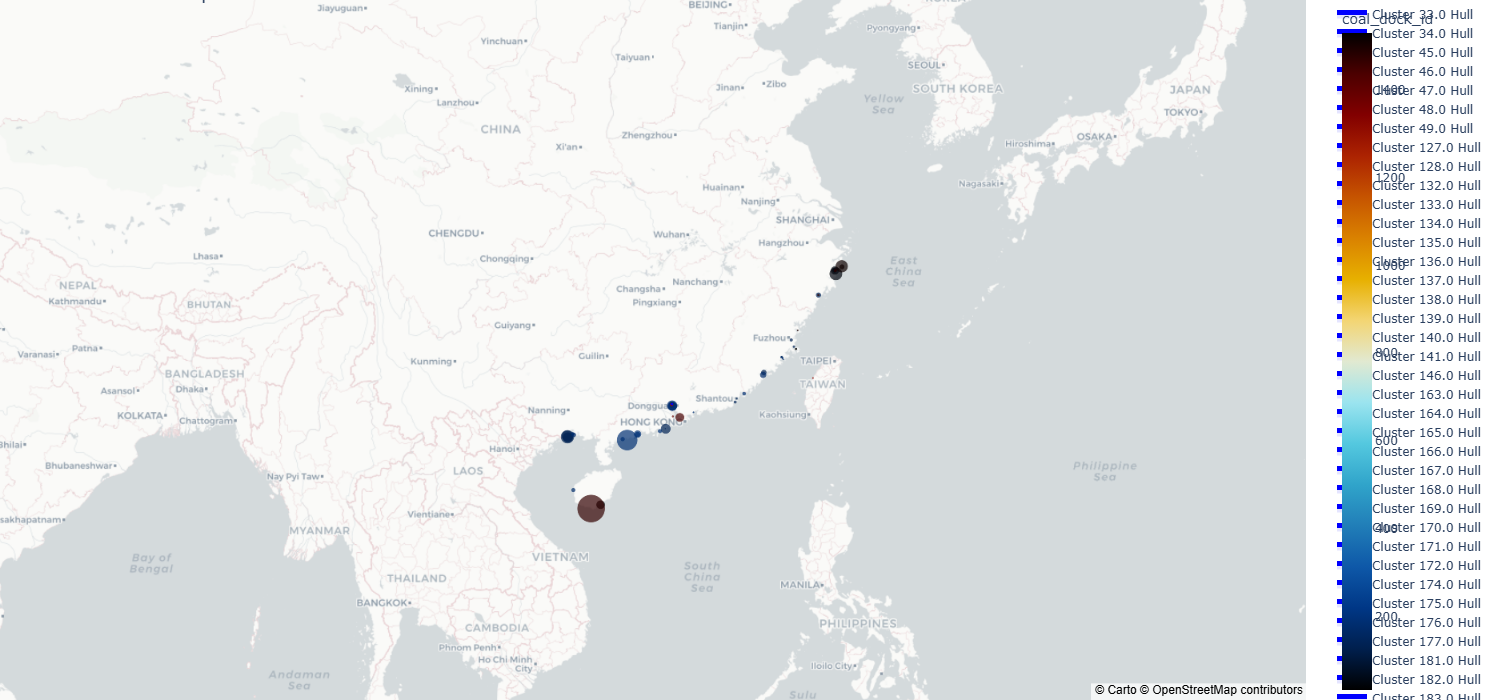

In [14]:


def plot_on_map(plot_df, hull_df, cluster_name):
    import plotly.express as px
    import plotly.graph_objects as go
    from scipy.spatial import ConvexHull
    

    fig = go.Figure()

    # Create a scatter mapbox plot with clusters
    fig = px.scatter_mapbox(
        plot_df,
        lat="lat",
        lon="lng",
        color=cluster_name,
        size="size",
        hover_name=cluster_name,
        hover_data={"size": True, "lat": True, "lng": True},
        title="Clusters on Map",
        color_continuous_scale=px.colors.cyclical.IceFire,
        zoom=5,
        height=600
    )
    
    # Calculate and add the convex hull for each cluster
    unique_clusters = hull_df[cluster_name].unique()
    
    for cluster in unique_clusters:
        if cluster == -1:  # Skip noise points
            continue
        cluster_points = hull_df[hull_df[cluster_name] == cluster][['lng', 'lat']].values
    
        if len(cluster_points) > 2:  # Convex hull requires at least 3 points
            try:
                hull = ConvexHull(cluster_points)
                hull_points = np.append(hull.vertices, hull.vertices[0])  # Append the first point to close the hull
                fig.add_trace(go.Scattermapbox(
                    lon=cluster_points[hull_points, 0],
                    lat=cluster_points[hull_points, 1],
                    mode='lines',
                    fill='toself',
                    fillcolor='rgba(0, 0, 255, 0.1)',  # Semi-transparent fill color
                    line=dict(color='blue'),
                    name=f'Cluster {cluster} Hull'
                ))
            except:
                print(f"cluster_id : {cluster} hull failed.")
    
    # Set the map style and layout
    fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_center={"lat": plot_df["lat"].mean(), "lon": plot_df["lng"].mean()},
        margin={"r":0,"t":0,"l":0,"b":0},
        height=700, width=1200
    )
    
    # fig.write_html(r'C:\Users\qiu\IdeaProjects\SISI\core\ShoreNet\notebooks\html\new.html')
    fig.show()


plot_on_map(plot_df, hull_df, 'coal_dock_id')

In [25]:
coal_mmsi_file_name = 'coal_mmsi.json'
rf = open(coal_mmsi_file_name, 'r')
coal_mmsi_dict = json.load(rf)
print(coal_mmsi_dict['mmsi'][:5], len(coal_mmsi_dict['mmsi']))
coal_mmsi_list = [int(m) for m in coal_mmsi_dict['mmsi']]
rf.close()

print(len(coal_mmsi_list))

for mmsi, group in south_china_with_polygon_sail_df.groupby('mmsi'):
    if not mmsi in coal_mmsi_list:
        print(int(mmsi), coal_mmsi_list[:5])

[696254464, 412352514.0, 411041794, 412352516.0, 229376006] 30141
30141
3 [696254464, 412352514, 411041794, 412352516, 229376006]
7 [696254464, 412352514, 411041794, 412352516, 229376006]
8 [696254464, 412352514, 411041794, 412352516, 229376006]
10 [696254464, 412352514, 411041794, 412352516, 229376006]
13 [696254464, 412352514, 411041794, 412352516, 229376006]
20 [696254464, 412352514, 411041794, 412352516, 229376006]
22 [696254464, 412352514, 411041794, 412352516, 229376006]
23 [696254464, 412352514, 411041794, 412352516, 229376006]
24 [696254464, 412352514, 411041794, 412352516, 229376006]
25 [696254464, 412352514, 411041794, 412352516, 229376006]
26 [696254464, 412352514, 411041794, 412352516, 229376006]
27 [696254464, 412352514, 411041794, 412352516, 229376006]
28 [696254464, 412352514, 411041794, 412352516, 229376006]
29 [696254464, 412352514, 411041794, 412352516, 229376006]
30 [696254464, 412352514, 411041794, 412352516, 229376006]
31 [696254464, 412352514, 411041794, 412352516

In [5]:
plot_row_list = []
hull_df_list = []
all_coal_gdf = all_coal_df.groupby('cluster')
print(len(all_coal_gdf))
for cluster_id, group in all_coal_gdf:
    first_row = group.iloc[0, :]
    if (group.shape[0] > 100) & (group['mmsi'].nunique() > 30):
        # get points data
        c_dict = {'cluster': cluster_id, 'size': group.shape[0], 'lng': first_row['lng'], 'lat': first_row['lat']}
        plot_row_list.append(c_dict)

        # get hull data
        num_rows = group.shape[0]
        num_select = int(num_rows * 1.0)
    
        # Randomly select row indices
        selected_indices = np.random.choice(num_rows, num_select, replace=False)
        hull_df_list.append(group.iloc[selected_indices, :])
        
plot_df = pd.DataFrame(plot_row_list)
print(plot_df.shape)
print(plot_df.head())

hull_df = pd.concat(hull_df_list, ignore_index=True)
hull_df.loc[:, 'mmsi'] = hull_df['mmsi'].astype(str)
print(hull_df.shape)
print(hull_df.head())

300
(116, 4)
   cluster  size         lng        lat
0        0  3707  120.199165  35.995968
1        1  5341  120.311966  36.087265
2        2   435  120.244102  36.028580
3        3   257  120.238731  36.018417
4        4  9480  121.719902  29.952801
(168133, 10)
        mmsi  begin_time    end_time  duration         lng        lat  \
0  412436363  1700473727  1700476232      2505  120.222466  36.013248   
1  477308116  1701430443  1701433673      3230  120.220047  36.010864   
2  413330654  1689135773  1689144081      8308  120.195419  35.994865   
3  232024771  1680307316  1680374639     67323  120.229202  36.010601   
4  413289040  1677628816  1677652016     23200  120.189064  36.002132   

   point_num Event_categories  coal_dock_id  cluster  
0          5      record_poly          20.0        0  
1         11      record_poly          20.0        0  
2          9      record_poly        1311.0        0  
3        775  stop_event_poly          20.0        0  
4        137  low_sp

In [6]:
plot_df.describe()

,cluster,size,lng,lat
count,116.000000,116.000000,116.000000,116.000000
mean,98.870690,1449.422414,120.384763,34.159161
std,69.703912,4839.544422,1.682654,3.847782
min,0.000000,101.000000,113.848076,29.723101
25%,39.750000,155.000000,119.436077,29.986188
50%,89.500000,271.500000,120.290058,35.272696
75%,149.250000,703.750000,121.989561,38.316619
max,289.000000,37762.000000,122.479950,40.748798


In [7]:
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
import numpy as np


fig = go.Figure()

# Create a scatter mapbox plot with clusters
fig = px.scatter_mapbox(
    plot_df,
    lat="lat",
    lon="lng",
    color="cluster",
    size="size",
    hover_name="cluster",
    hover_data={"size": True, "lat": True, "lng": True},
    title="Clusters on Map",
    color_continuous_scale=px.colors.cyclical.IceFire,
    zoom=5,
    height=600
)

# Calculate and add the convex hull for each cluster
unique_clusters = hull_df['cluster'].unique()

for cluster in unique_clusters:
    if cluster == -1:  # Skip noise points
        continue
    cluster_points = hull_df[hull_df['cluster'] == cluster][['lng', 'lat']].values

    if len(cluster_points) > 2:  # Convex hull requires at least 3 points
        try:
            hull = ConvexHull(cluster_points)
            hull_points = np.append(hull.vertices, hull.vertices[0])  # Append the first point to close the hull
            fig.add_trace(go.Scattermapbox(
                lon=cluster_points[hull_points, 0],
                lat=cluster_points[hull_points, 1],
                mode='lines',
                fill='toself',
                fillcolor='rgba(0, 0, 255, 0.1)',  # Semi-transparent fill color
                line=dict(color='blue'),
                name=f'Cluster {cluster} Hull'
            ))
        except:
            print(f"cluster_id : {cluster} hull failed.")

# Set the map style and layout
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": plot_df["lat"].mean(), "lon": plot_df["lng"].mean()},
    margin={"r":0,"t":0,"l":0,"b":0},
    height=1000, width=2000
)

fig.write_html(r'C:\Users\qiu\IdeaProjects\SISI\core\ShoreNet\notebooks\html\new.html')
print('Done!')


Done!


In [30]:
import matplotlib.pyplot as plt
from simplification.cutil import simplify_coords

# Simplify the polygon using Ramer-Douglas-Peucker algorithm
def simplify_polygon(polygon, tolerance):
    return simplify_coords(polygon, tolerance)

# Function to compute convex hull and return the coordinates
def compute_convex_hull(df):
    unique_clusters = df['cluster'].unique()
    hulls = {}
    
    for cluster in unique_clusters:
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        if len(cluster_points) > 2:  # Convex hull requires at least 3 points
            try:
                hull = ConvexHull(cluster_points)
                hull_points = cluster_points[hull.vertices]
                if len(hull_points) > max_points:
                    hull_points = simplify_polygon(hull_points, tolerance=0.001)
                hulls[cluster] = hull_points
            except QhullError as e:
                print(f"QhullError for cluster {cluster}: {e}")
        else:
            hulls[cluster] = cluster_points  # For less than 3 points, just use the points themselves
    
    return hulls

# test_hull_df = hull_df.loc[hull_df['cluster']==2283]
hulls = compute_convex_hull(hull_df)

# Display hull coordinates for each cluster
for cluster, points in hulls.items():
    print(f"Cluster {cluster} hull coordinates:")
    for point in points:
        print(f"({point[0]}, {point[1]})")

    
# Plot points and their convex hulls using matplotlib
plt.figure(figsize=(10, 8))

# Plot points
plt.scatter(test_hull_df['lng'], test_hull_df['lat'], c=test_hull_df['cluster'], cmap='viridis', label='Points')

# Plot convex hulls
for cluster, points in hulls.items():
    if len(points) > 2:  # Plot hulls only if there are enough points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r-')
    plt.scatter(points[:, 0], points[:, 1], s=30, label=f'Cluster {cluster}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Points and Convex Hulls')
plt.legend()
plt.show()

In [50]:
# save hull polygon to sql server
# Insert polygon data

# Connect to SQL Server
from core.ShoreNet.conf import sql_server_properties

conn = pymssql.connect(sql_server_properties['host'], sql_server_properties['user'], 
                       'Amacs@0212', sql_server_properties['database'])
cursor = conn.cursor()

# Insert polygon data
insert_query = """
INSERT INTO ShoreNet.tab_dock_polygon (Name, type_id, lng, lat, Polygon)
VALUES ('%s', %d, %f, %f, geometry::STGeomFromText('%s', 4326));
"""

for cluster, points in hulls.items():
    cluster_polygon_points = []
    for point in points:
        # print(f"cluster: {cluster}: ({point[0]}, {point[1]})")
        cluster_polygon_points.append([round(point[0], 6), round(point[1], 6)])
    cluster_polygon_points.append([round(points[0][0], 6), round(points[0][1], 6)])
    name = f"dbscan_cluster_{cluster}"
    polygon_wkt = f"POLYGON(({', '.join([f'{lon} {lat}' for lon, lat in cluster_polygon_points])}))"
    type_id = 6
    lng = cluster_polygon_points[0][0]
    lat = cluster_polygon_points[0][1]
    q = insert_query % (name, type_id, lng, lat, polygon_wkt)
    cursor.execute(q)

conn.commit()

# Close the connection
cursor.close()
conn.close()

cluster: 0: (120.2791976928711, 36.01900100708008)
cluster: 0: (120.27760314941406, 36.01459884643555)
cluster: 0: (120.27760314941406, 36.01150131225586)
cluster: 0: (120.2780990600586, 36.01029968261719)
cluster: 0: (120.2843017578125, 36.01169967651367)
cluster: 0: (120.28469848632812, 36.01253128051758)
cluster: 0: (120.2845687866211, 36.01366424560547)
cluster: 0: (120.2829818725586, 36.01873016357422)
cluster: 0: (120.28009796142578, 36.01900100708008)
cluster: 1: (120.30484771728516, 36.07184982299805)
cluster: 1: (120.31080627441406, 36.07061004638672)
cluster: 1: (120.32551574707031, 36.092681884765625)
cluster: 1: (120.32559967041016, 36.09281539916992)
cluster: 1: (120.32740783691406, 36.0966911315918)
cluster: 1: (120.3274154663086, 36.096961975097656)
cluster: 1: (120.32717895507812, 36.09806442260742)
cluster: 1: (120.32489776611328, 36.10029983520508)
cluster: 1: (120.32430267333984, 36.100799560546875)
cluster: 1: (120.32351684570312, 36.10121536254883)
cluster: 1: (120

[[119.634589, 39.928916], [119.649268, 39.934595], [119.658406, 39.916476], [119.643994, 39.911809], [119.634589, 39.928916]]
[[119.691135, 39.944795], [119.692236, 39.907221], [119.671542, 39.907226], [119.663966, 39.92188], [119.659858, 39.943066], [119.691135, 39.944795]]


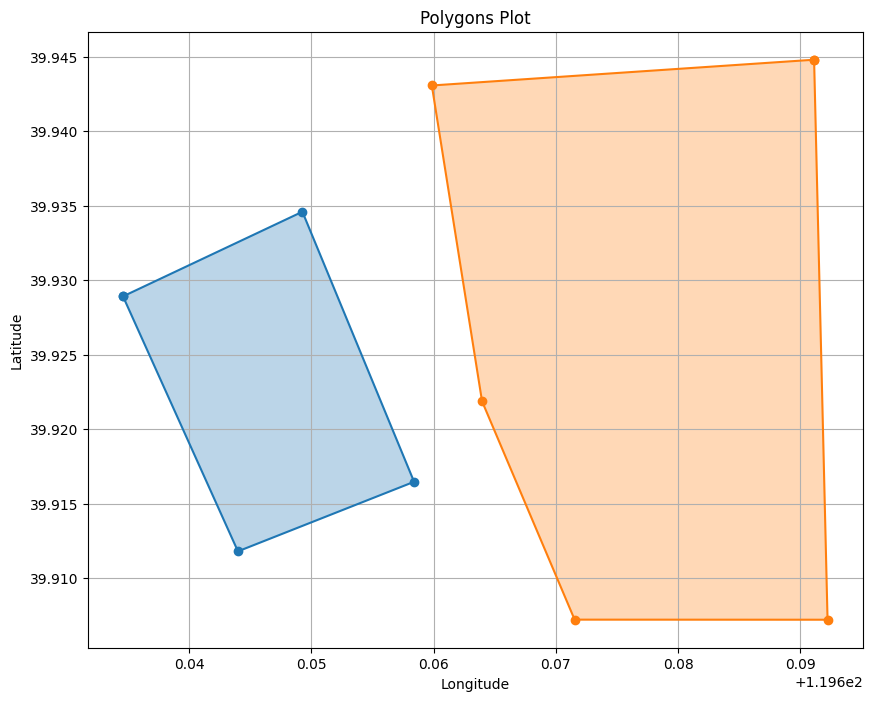

In [19]:
qhd_dock_df = dock_df.loc[dock_df['Id'].isin([9, 10])]

# Create a plot
plt.figure(figsize=(10, 8))

for _, row in qhd_dock_df.iterrows():
    wkt_polygon = row['Polygon']
    pattern = re.compile(r'\d+\.\d+\s\d+\.\d+')
    matches = pattern.findall(wkt_polygon)
    coordinates = [[float(coord) for coord in match.split()] for match in matches]
    print(coordinates)
    polygon = np.array(coordinates)  # Convert to numpy array
    plt.plot(polygon[:, 0], polygon[:, 1], marker='o')
    plt.fill(polygon[:, 0], polygon[:, 1], alpha=0.3)  # Fill the polygon with some transparency

# Set plot labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Polygons Plot')
plt.grid(True)

# Show the plot
plt.show()

In [10]:
# load data from sql server
conn = pymssql.connect(server, user, password, database)

cleaned_coal_sail_query = f"""
SELECT
	t1.mmsi as mmsi,
	t1.Begin_time as begin_time,
	t1.End_time as end_time,
    t1.Begin_lon as begin_lng,
    t1.Begin_lat as begin_lat,
    t1.nowPortName as now_port_name,
	t1.nowDockName as now_dock_name,
	t1.coal_dock_id as now_polygon_id,
	t2.Name as now_polygon_name,
	t2.Province as now_polygon_province,
	t3.ship_type as ship_type
FROM
(SELECT
    mmsi, Begin_time, End_time, Begin_lon, Begin_lat, nowPortName, nowDockName, coal_dock_id
FROM
    sisi.ShoreNet.tab_sailing_log A
WHERE
    coal_dock_id is NOT NULL
    -- and (A.Event_categories != 'record_poly')
) t1
JOIN (
	SELECT
		Id, Name, Province
	FROM
		sisi.ShoreNet.tab_dock_polygon tdp
) t2 ON t1.coal_dock_id = t2.Id
JOIN (
	SELECT
		mmsi, ship_type
	FROM
		sisi.ShoreNet.dim_ships_static dss
) t3 ON t3.mmsi = t1.mmsi
"""

cleaned_sail_query = f"""
SELECT
	t1.mmsi as mmsi,
	t1.Begin_time as begin_time,
	t1.End_time as end_time,
    t1.Begin_lon as begin_lng,
    t1.Begin_lat as begin_lat,
    t1.nowPortName as now_port_name,
	t1.nowDockName as now_dock_name,
	t1.coal_dock_id as now_polygon_id,
	t2.Name as now_polygon_name,
	t2.Province as now_polygon_province,
	t3.ship_type as ship_type
FROM
(SELECT
    mmsi, Begin_time, End_time, Begin_lon, Begin_lat, nowPortName, nowDockName, coal_dock_id
FROM
    sisi.ShoreNet.tab_sailing_log A
) t1
JOIN (
	SELECT
		Id, Name, Province
	FROM
		sisi.ShoreNet.tab_dock_polygon tdp
) t2 ON t1.coal_dock_id = t2.Id
JOIN (
	SELECT
		mmsi, ship_type
	FROM
		sisi.ShoreNet.dim_ships_static dss
) t3 ON t3.mmsi = t1.mmsi
"""

cleaned_coal_sail_df = pd.read_sql(
    sql=cleaned_coal_sail_query, con=conn
)

cleaned_sail_df = pd.read_sql(
    sql=cleaned_sail_query, con=conn
)
conn.close()

# cleaned_coal_sail_df = cleaned_coal_sail_df.loc[~((cleaned_coal_sail_df['now_polygon_name'].str.contains('拓展')) |
#                                                   (cleaned_coal_sail_df['now_polygon_name'].str.contains('船坞')))]

print(f"停泊日志标记比例: {100 * (cleaned_coal_sail_df.shape[0] / cleaned_sail_df.shape[0])} %")

cleaned_coal_sail_df.sort_values(by=['mmsi', 'begin_time'])
print(cleaned_coal_sail_df['mmsi'].nunique())
print(cleaned_coal_sail_df.shape)
cleaned_coal_sail_df.head()

C:\Users\qiu\AppData\Local\Temp\ipykernel_31292\1656482488.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cleaned_coal_sail_df = pd.read_sql(
C:\Users\qiu\AppData\Local\Temp\ipykernel_31292\1656482488.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cleaned_sail_df = pd.read_sql(


停泊日志标记比例: 100.0 %
6384
(58243, 11)


,mmsi,begin_time,end_time,begin_lng,begin_lat,now_port_name,now_dock_name,now_polygon_id,now_polygon_name,now_polygon_province,ship_type
0,413330690,1690848029,1691114108,119.514000,35.327000,rizhao,rizhao11,22,日照煤炭1号码头,山东省,33
1,413330890,1672531214,1672967279,120.386002,36.054001,qingdao,-1,16,青岛客运2号,山东省,90
2,413330890,1672531214,1673068980,120.386002,36.054001,qingdao,-1,16,青岛客运2号,山东省,90
3,413330890,1685577758,1686959977,120.732002,36.327999,None,None,31,拓展码头1号,山东省,90
4,413330890,1687046912,1687132760,120.733002,36.328999,None,None,31,拓展码头1号,山东省,90


In [58]:
records_list = []

for mmsi, group in cleaned_coal_sail_df.groupby('mmsi'):
    if group.shape[0] <= 1:
        continue
    elif group['now_port_name'].nunique() < 2:
        continue
    
    group.loc[:, 'next_dock_name'] = group['now_dock_name'].shift(-1)
    group.loc[:, 'next_polygon_id'] = group['now_polygon_id'].shift(-1)
    group.loc[:, 'next_polygon_name'] = group['now_polygon_name'].shift(-1)
    group.loc[:, 'next_port_name'] = group['now_port_name'].shift(-1)
    group.loc[:, 'next_dock_arrive_time'] = group['begin_time'].shift(-1)
    group.loc[:, 'next_port_lng'] = group['begin_lng'].shift(-1)
    group.loc[:, 'next_port_lat'] = group['begin_lat'].shift(-1)

    for _, row in group.iterrows():
        if (row['now_polygon_name'] != row['next_polygon_name']) & (row['now_port_name'] != row['next_port_name']):
            if (not row['next_polygon_name'] is None) & (~np.isnan(row['next_dock_arrive_time'])):
                stop_duration = (row['end_time'] - row['begin_time']) / (3600 * 24)
                sail_duration = (row['next_dock_arrive_time'] - row['end_time']) / (3600 * 24)
                if (stop_duration > 0.25) & (stop_duration < 30): 
                    records_list.append([mmsi, row['now_port_name'], row['begin_lng'], row['begin_lat'], 
                                         row['next_port_name'], row['next_port_lng'], row['next_port_lat'],
                                         float(f"{sail_duration:.2f}")])

records_df = pd.DataFrame(records_list, columns=['mmsi', 'depart_port', 'depart_lng', 'depart_lat', 
                                                 'dest_port', 'dest_lng', 'dest_lat', 'sail_duration'])
print(records_df.dtypes)
records_df.to_csv(rf"C:\Users\qiu\OneDrive\文档\SISI\3沿海干散货研究\data\coal_log_data\2023_coal_depart_dest_ports.csv", index=False, encoding='utf-8-sig')
records_df.describe()

mmsi               int64
depart_port       object
depart_lng       float64
depart_lat       float64
dest_port         object
dest_lng         float64
dest_lat         float64
sail_duration    float64
dtype: object


,mmsi,depart_lng,depart_lat,dest_lng,dest_lat,sail_duration
count,1.922000e+03,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000
mean,4.169292e+08,118.416234,34.341022,118.286302,34.565936,84.014948
std,4.996726e+07,3.252772,6.086223,3.232640,6.135602,77.469966
min,1.523450e+08,108.300003,19.101000,108.300003,19.101200,0.000000
25%,4.132381e+08,117.878998,29.937525,117.875702,30.856575,21.257500
50%,4.133768e+08,119.007053,38.317951,118.993774,38.321999,60.690000
75%,4.141500e+08,120.234274,38.980999,119.677597,38.979000,124.465000
max,7.890000e+08,122.207298,40.316002,122.209999,40.320000,352.640000


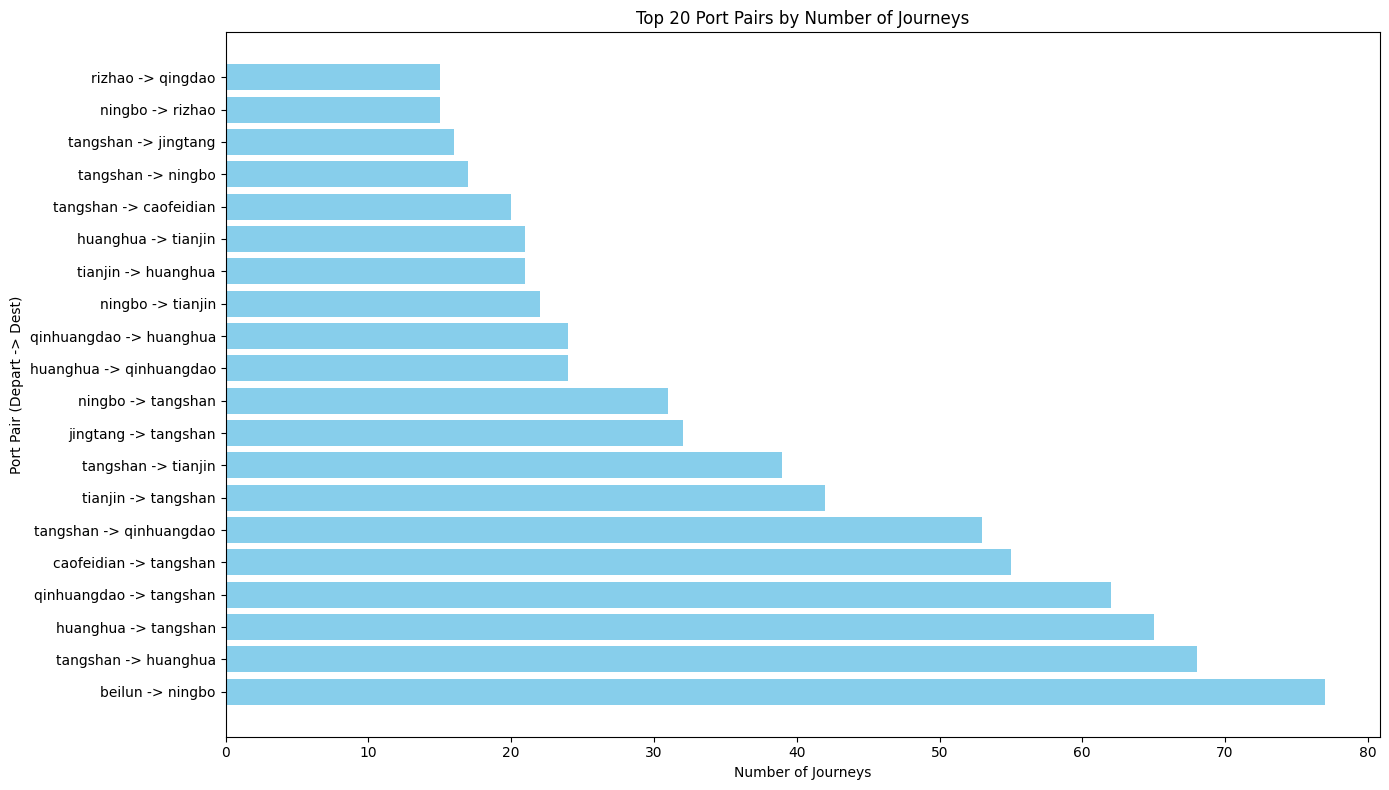

In [120]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the top port pairs (depart, dest) count
top_port_pairs = df.groupby(['depart_port', 'dest_port']).size().reset_index(name='count')
top_port_pairs = top_port_pairs.sort_values(by='count', ascending=False).head(20)

# Plotting the top port pairs
plt.figure(figsize=(14, 8))
plt.barh(top_port_pairs.apply(lambda x: f"{x['depart_port']} -> {x['dest_port']}", axis=1), top_port_pairs['count'], color='skyblue')
plt.xlabel('Number of Journeys')
plt.ylabel('Port Pair (Depart -> Dest)')
plt.title('Top 20 Port Pairs by Number of Journeys')
plt.tight_layout()
plt.show()


C:\Users\qiu\AppData\Local\Temp\ipykernel_7116\1179930206.py:16: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



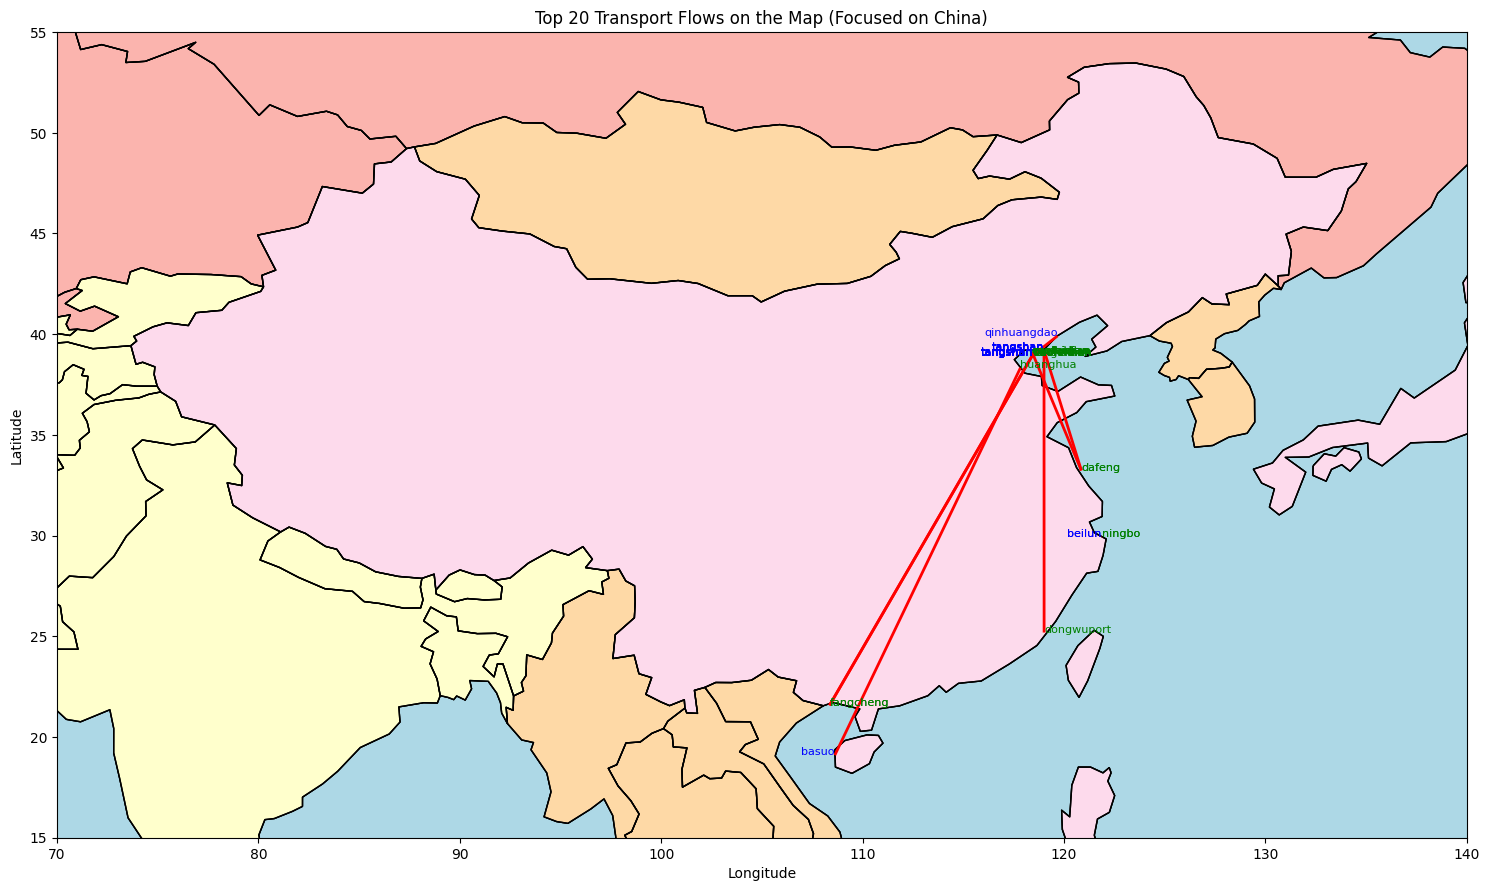

In [118]:
import geopandas as gpd
from shapely.geometry import LineString

# Calculate the top 20 port pairs (depart, dest) count
top_port_pairs = df.groupby(['depart_port', 'dest_port', 'depart_lng', 'depart_lat', 'dest_lng', 'dest_lat']).size().reset_index(name='count')
top_port_pairs = top_port_pairs.sort_values(by='count', ascending=False).head(20)

# Create GeoDataFrame for the top transport flows
lines = []
for idx, row in top_port_pairs.iterrows():
    lines.append(LineString([(row['depart_lng'], row['depart_lat']), (row['dest_lng'], row['dest_lat'])]))

gdf = gpd.GeoDataFrame(top_port_pairs, geometry=lines)

# Plotting the transport flows on the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1, color='black')
world.plot(ax=ax, color='white', edgecolor='black')

# Add ocean and land colors
ax.set_facecolor('lightblue')

# Plotting countries with different colors for better visualization
world.plot(ax=ax, cmap='Pastel1', edgecolor='black')

# Focusing on China
ax.set_xlim([70, 140])
ax.set_ylim([15, 55])

# Plot transport flows with more distinctive color
gdf.plot(ax=ax, color='red', linewidth=2)

# Adding port names to the start and end of the lines
for idx, row in top_port_pairs.iterrows():
    ax.text(row['depart_lng'], row['depart_lat'], row['depart_port'], fontsize=8, ha='right', color='blue')
    ax.text(row['dest_lng'], row['dest_lat'], row['dest_port'], fontsize=8, ha='left', color='green')

plt.title('Top 20 Transport Flows on the Map (Focused on China)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

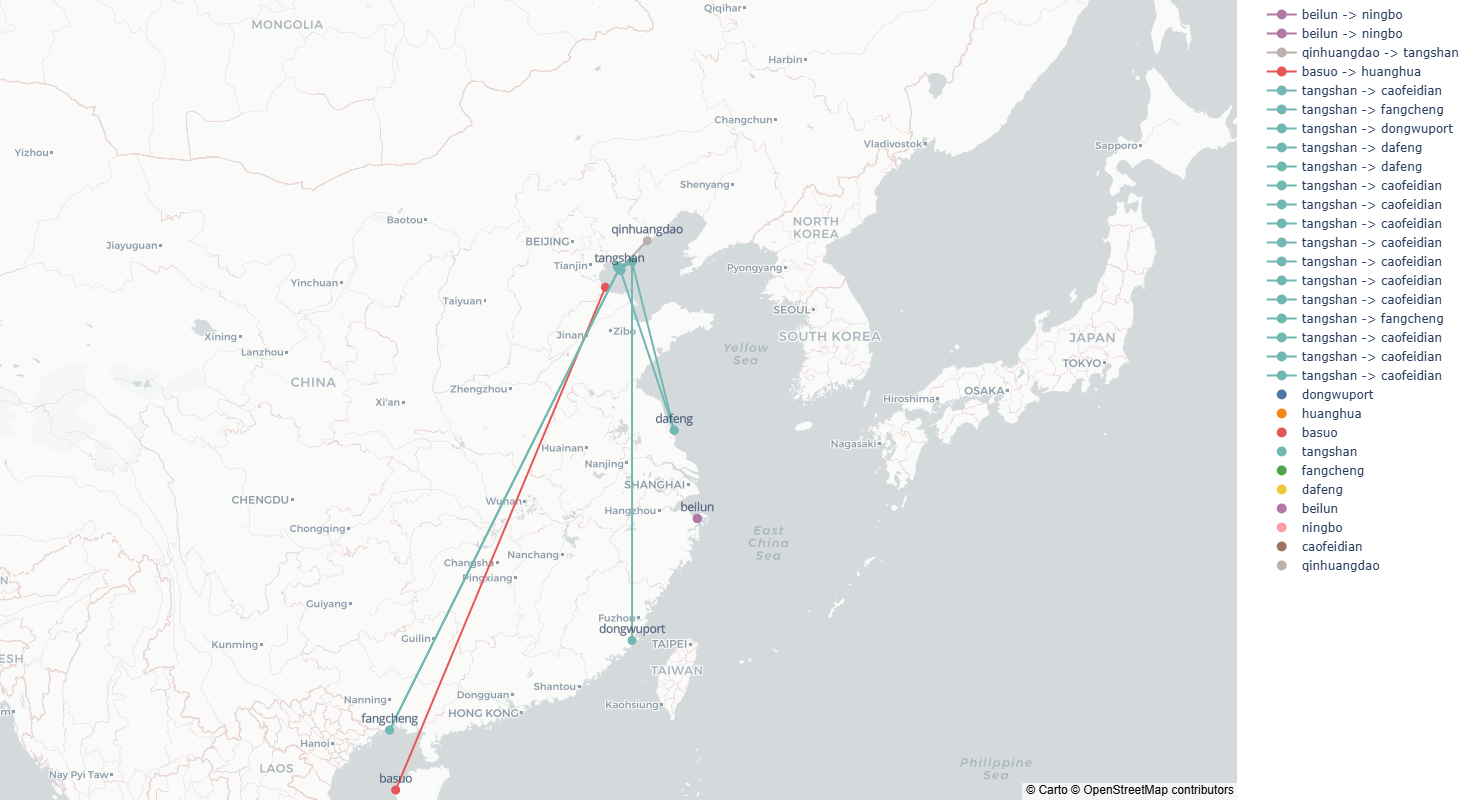

In [119]:
import plotly.graph_objects as go
import plotly.express as px

# Calculate the top 20 port pairs (depart, dest) count
top_port_pairs = df.groupby(['depart_port', 'dest_port', 'depart_lng', 'depart_lat', 'dest_lng', 'dest_lat']).size().reset_index(name='count')
top_port_pairs = top_port_pairs.sort_values(by='count', ascending=False).head(20)

# Generate unique colors for each port
ports = list(set(top_port_pairs['depart_port']).union(set(top_port_pairs['dest_port'])))
colors = px.colors.qualitative.T10[:len(ports)]
port_color_map = {port: colors[i] for i, port in enumerate(ports)}

# Create the figure
fig = go.Figure()

# Add transport flows
for idx, row in top_port_pairs.iterrows():
    fig.add_trace(go.Scattermapbox(
        lon=[row['depart_lng'], row['dest_lng']],
        lat=[row['depart_lat'], row['dest_lat']],
        mode='markers+lines+text',
        marker={'size': 10, 'color': port_color_map[row['depart_port']]},
        line=dict(width=2, color=port_color_map[row['depart_port']]),
        text=[row['depart_port'], row['dest_port']],
        textposition='top center',
        name=f"{row['depart_port']} -> {row['dest_port']}"
    ))

# Set the map configuration
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": df["depart_lat"].mean(), "lon": df["depart_lng"].mean()},
    mapbox=dict(
        zoom=4
    ),
    margin={"r":0,"t":0,"l":0,"b":0},
    showlegend=True,
    width=800,
    height=800,
)

# Add legend
for port, color in port_color_map.items():
    fig.add_trace(go.Scattermapbox(
        lon=[None],
        lat=[None],
        mode='markers',
        marker={'size': 10, 'color': color},
        name=port
    ))

# Show the plot
fig.show()

count    1922.000000
mean       84.014948
std        77.469966
min         0.000000
25%        21.257500
50%        60.690000
75%       124.465000
max       352.640000
Name: sail_duration, dtype: float64


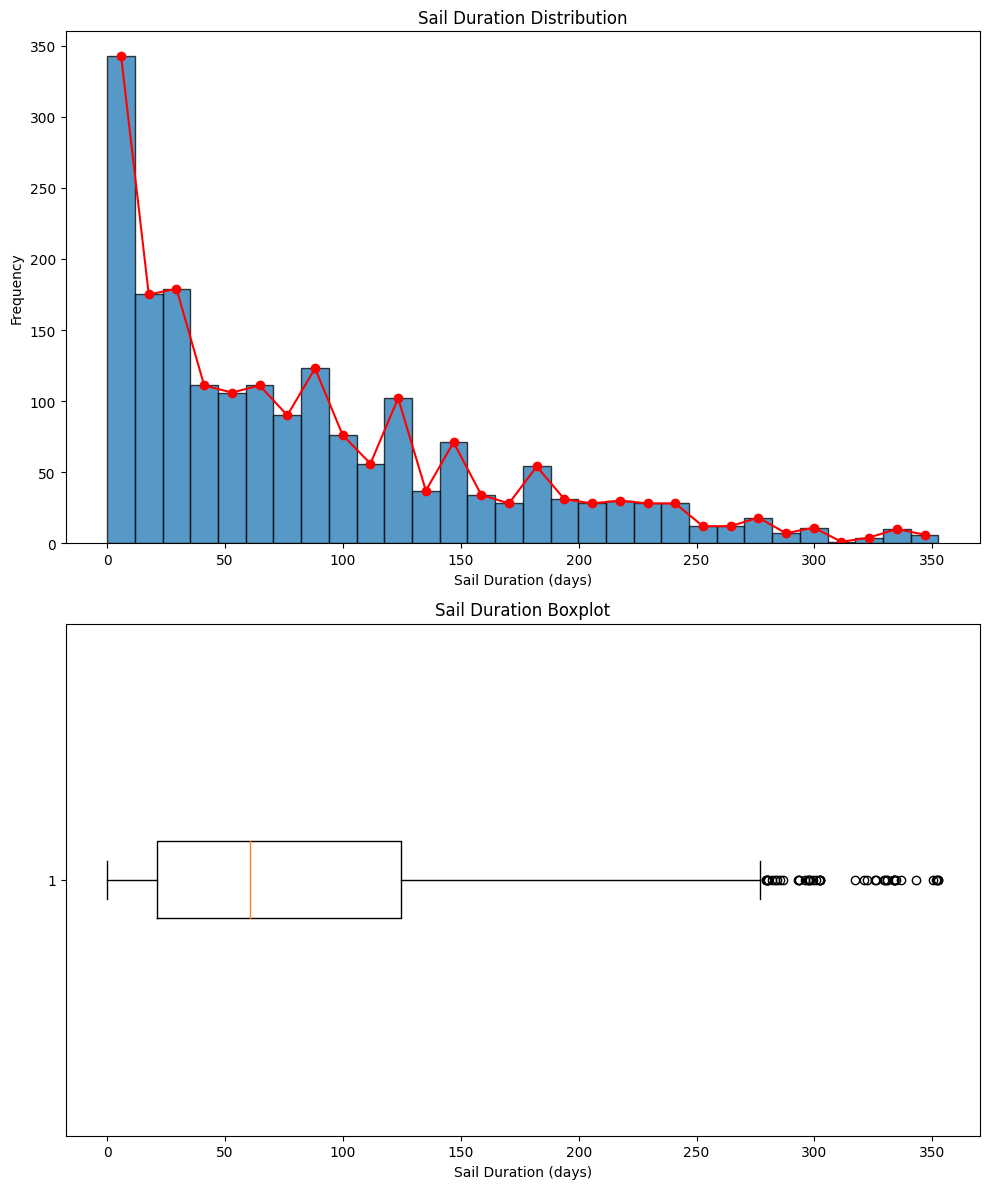

In [122]:
# Plotting Sail Duration Histogram with a Boxplot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

print(df['sail_duration'].describe())

# Histogram
n, bins, patches = ax[0].hist(df['sail_duration'], bins=30, alpha=0.75, edgecolor='black')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
ax[0].plot(bin_centers, n, '-o', color='red')
ax[0].set_title('Sail Duration Distribution')
ax[0].set_xlabel('Sail Duration (days)')
ax[0].set_ylabel('Frequency')

# Boxplot
ax[1].boxplot(df['sail_duration'], vert=False)
ax[1].set_title('Sail Duration Boxplot')
ax[1].set_xlabel('Sail Duration (days)')

plt.tight_layout()
plt.show()

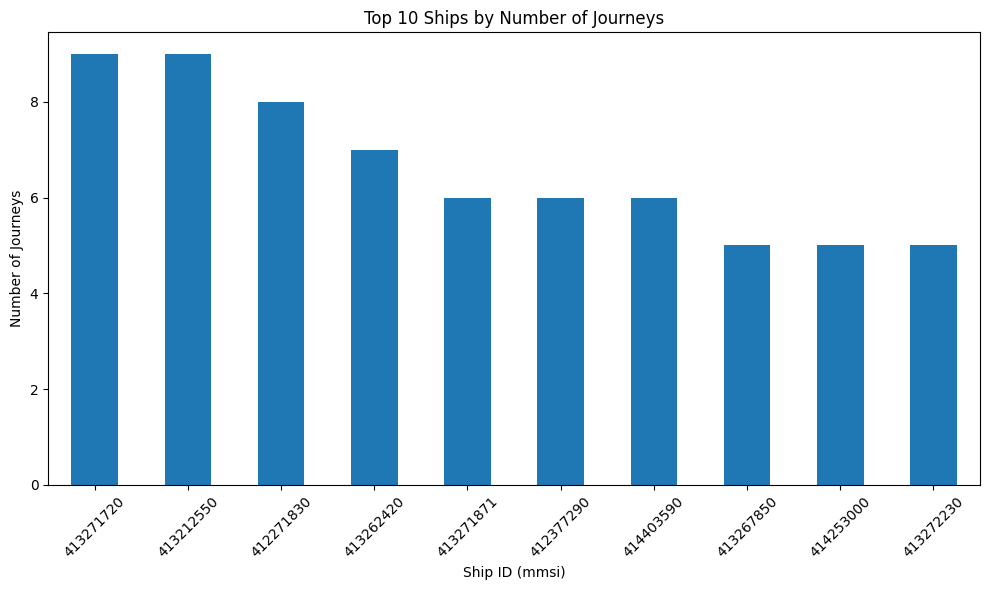

In [50]:
# Journey Counts per Ship
journey_counts_per_ship = df['mmsi'].value_counts()

# Plotting Journey Counts per Ship
plt.figure(figsize=(10, 6))
journey_counts_per_ship.head(10).plot(kind='bar')
plt.title('Top 10 Ships by Number of Journeys')
plt.xlabel('Ship ID (mmsi)')
plt.ylabel('Number of Journeys')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


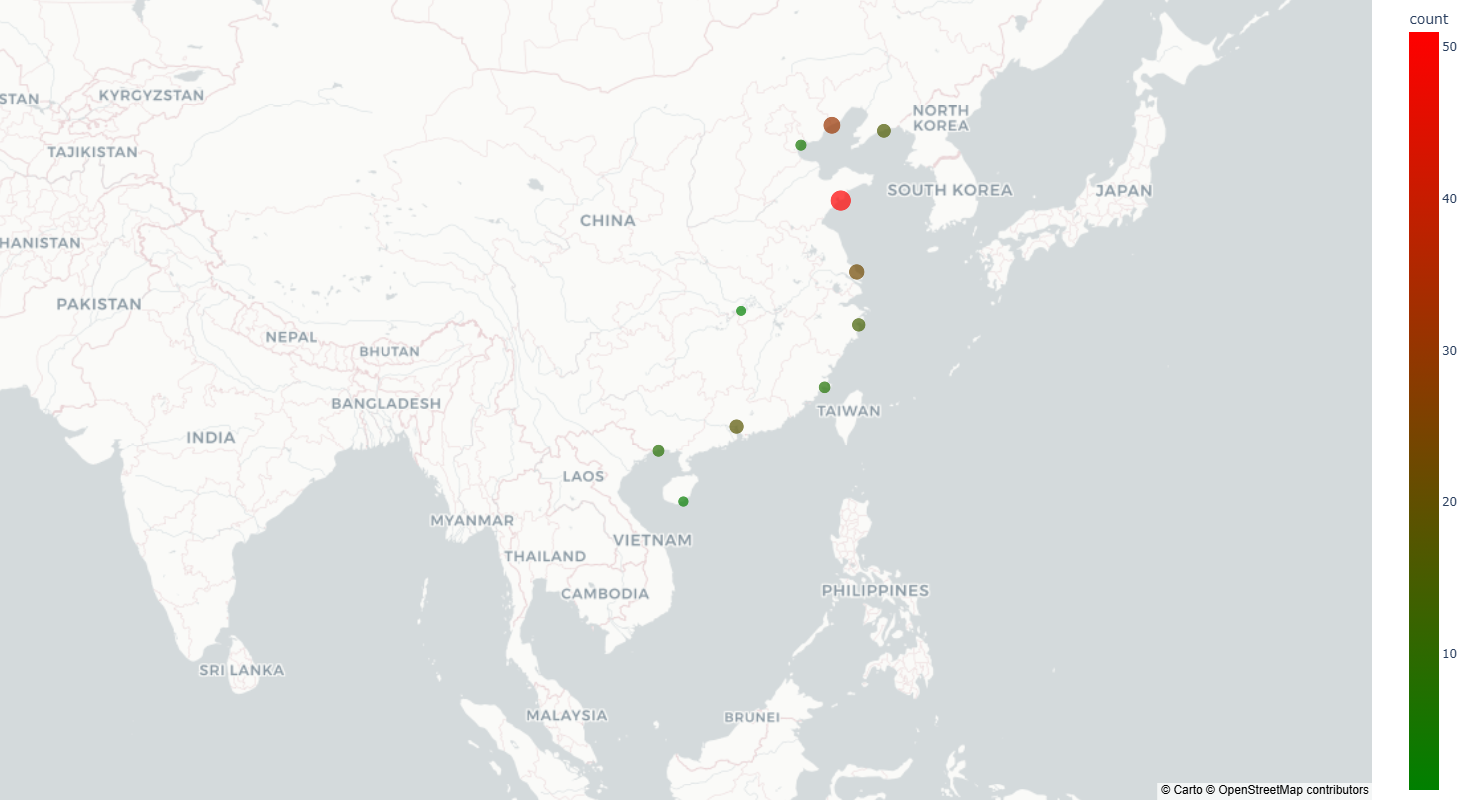

In [99]:
# Load the CSV file
file_path = rf"C:\Users\qiu\OneDrive\文档\SISI\3沿海干散货研究\data\sisi_ShoreNet_tab_dock_polygon.csv"
df = pd.read_csv(file_path)

# Group by District and count the number of occurrences for each district
grouped_df = df.groupby('Province').agg({'lng': 'first', 'lat': 'first', 'Province': 'size'}).rename(columns={'Province': 'count'}).reset_index()

# Normalize sizes to ensure a minimum size of 4
min_marker_size = 4
max_marker_size = 15

# Normalize the counts to the range [min_marker_size, max_marker_size]
grouped_df['size'] = ((grouped_df['count'] - grouped_df['count'].min()) / 
                      (grouped_df['count'].max() - grouped_df['count'].min()) * 
                      (max_marker_size - min_marker_size) + min_marker_size)

# Define custom color scale from purple to red
color_scale = [
    [0, 'green'],
    [1, 'red']
]

# Plot markers on the map with custom color scale and size related to count
fig = px.scatter_mapbox(grouped_df, 
                        lat="lat", 
                        lon="lng", 
                        hover_name="Province", 
                        hover_data=["count"], 
                        color="count",
                        size="size",
                        color_continuous_scale=color_scale,
                        size_max=max_marker_size,
                        zoom=4,
                        mapbox_style="carto-positron")

fig.update_layout(
    mapbox_center={"lat": grouped_df["lat"].mean(), "lon": grouped_df["lng"].mean()},
    margin={"r":0,"t":0,"l":0,"b":0}, width=800,
    height=800,
)

fig.show()

In [74]:
# Group by Province and count the number of occurrences for each province
grouped_province_df = df.groupby('Province').size().reset_index(name='count')

# Plot pie chart
fig = px.pie(grouped_province_df, 
             names='Province', 
             values='count', 
             title='Distribution of Counts by Province',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             hover_data=['count'])

# Add count values on the pie chart
fig.update_traces(textinfo='label+percent+value', textposition='inside')
fig.update_layout( width=800, height=800)

fig.show()

KeyError: 'Province'

C:\Users\qiu\AppData\Local\Temp\ipykernel_37616\2378399266.py:12: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



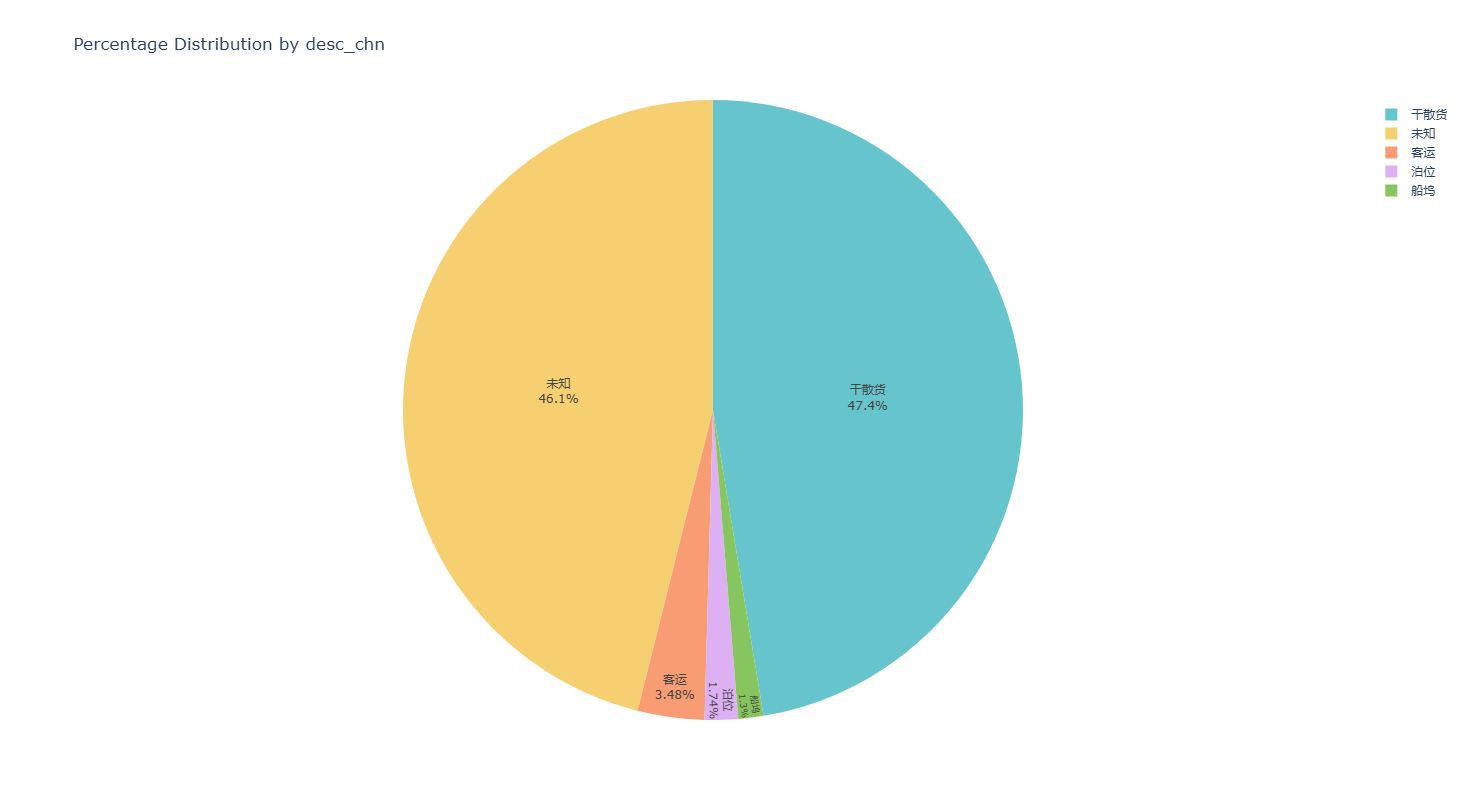

In [73]:
# df = pd.read_csv(rf"C:\Users\qiu\OneDrive\文档\SISI\3沿海干散货研究\data\Result_3.csv")

server = '127.0.0.1'
user = 'sa'
password = 'Amacs@0212'
database = 'sisi'

# Connect to SQL Server
conn = pymssql.connect(server, user, password, database)
cursor = conn.cursor()

df = pd.read_sql(
    sql=f"""
    SELECT
        Name,
        A.type_id as type_id,
        B.polygon_type_sec_chn as desc_chn
    FROM (
        select Name, type_id
        from sisi.ShoreNet.tab_dock_polygon
         ) A join (
             select
                 type_id, polygon_type_sec_chn
             from
                 sisi.ShoreNet.dim_polygon_type
             where
                 type_id != 6
    ) B on A.type_id = B.type_id
    """,
    con=conn
)

# Close the connection
conn.close()

# Group by desc_chn and count the number of occurrences for each value
grouped_desc_df = df.groupby('desc_chn').size().reset_index(name='count')

# Calculate the percentage for each value
grouped_desc_df['percentage'] = (grouped_desc_df['count'] / grouped_desc_df['count'].sum()) * 100
# print(grouped_desc_df)

# Plot pie chart for percentage
fig = px.pie(grouped_desc_df, 
             names='desc_chn', 
             values='percentage', 
             title='Percentage Distribution by desc_chn',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             hover_data=['count', 'percentage'])

# Add percentage values on the pie chart
fig.update_traces(textinfo='label+percent', textposition='inside')

fig.update_layout(width=800, height=800)

fig.show()

# backup

## B1 Plot polygon html

In [35]:
dock_polygon_df = pd.DataFrame(dock_polygon_list)
dbscan_polygon_df = dock_polygon_df.loc[dock_polygon_df['name'].str.contains('dbscan')]
dbscan_polygon_df.sort_values(by='lat', inplace=True)
dbscan_polygon_df.reset_index(inplace=True)

def plot_polygon(df, part_id, max_part):
    # Create a scatter mapbox plot with dock points
    fig = go.Figure()
    
    d_count = 0
    for _, row in df.iterrows():
        if not 'dbscan' in row['name']:
            continue
            
        points = np.array(row['polygon'])
        lat = points[:, 0]
        lng = points[:, 1]
        fig.add_trace(go.Scattermapbox(
            lon=lng,
            lat=lat,
            mode='lines',
            fill='toself',
            fillcolor='rgba(0, 0, 255, 0.2)',
            line=dict(color='blue'),
            name=f"Dock {row['dock_id']} Polygon",
            text=f"dock_id: {row['dock_id']}"
        ))
            
    # Set the map style and layout
    fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_center={"lat": df['lat'].mean(), "lon": df['lng'].mean()},
        mapbox_zoom=5,
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        height=700,
        width=1200
    )
    # fig.show()
    fig.write_html(rf"D:\data\sisi\dock\dbscan_hull_polygon_{part_id}_{max_part}.html")

# plot by n chunks
chunk_size = 300
dbscan_polygon_splits = [dbscan_polygon_df.iloc[i:i+chunk_size, :] for i in range(0, dbscan_polygon_df.shape[0], chunk_size)]

for _, df in enumerate(dbscan_polygon_splits):
    plot_polygon(df, _, len(dbscan_polygon_splits)-1)


C:\Users\qiu\AppData\Local\Temp\ipykernel_32544\2426230434.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 3 add dock tag into sailing logs

In [3]:
# find dock
from core.ShoreNet.scripts.parse_kml import parse_kml
from core.ShoreNet.scripts.extensive_dock_dbscan import find_dock

import platform
os_name = platform.system()
if os.name == 'nt' or os_name == 'Windows':
    DATA_PATH = r"D:/data/sisi/"
elif os.name == 'posix' or os_name == 'Linux':
    DATA_PATH = r"/mnt/d/data/sisi/"
else:
    DATA_PATH = "/mnt/d/data/sisi/"

file_name = os.path.join(DATA_PATH, 'dock/docks_stage_2.kml')
dock_polygon_list = parse_kml(file_name)
print(f"dock polygon count: {len(dock_polygon_list)}")

from tqdm.auto import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

dock_tag = coal_sail_df.parallel_apply(find_dock, args=(dock_polygon_list, ), axis=1)
coal_sail_df.loc[:, 'coal_dock_name'] = dock_tag
coal_sail_df.head()

dock polygon count: 205
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


C:\Users\qiu\AppData\Local\Temp\ipykernel_384\327529760.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coal_sail_df.loc[:, 'coal_dock_name'] = dock_tag


,mmsi,Begin_time,End_time,Begin_lon,Begin_lat,Point_num,avgSpeed,nowPortName,nowPortId,nowDockName,nowBerthName,Event_categories,coal_dock_name
194966,100000012,1693588557,1693605576,121.690201,32.142200,12,0.000000,lusi,3421.0,-1,-1,low_speed_event,None
194967,100000012,1693613290,1693734166,121.479881,32.129550,117,0.671072,NaN,NaN,NaN,NaN,low_speed_event,拓展码头2号
194968,100000012,1694127931,1694141846,121.925955,28.555756,14,0.800750,taizhouanch,3581.0,-1,-1,low_speed_event,None
194972,100000012,1694320694,1694321426,121.867346,28.718481,2,0.000000,taizhouanch,3581.0,-1,-1,low_speed_event,None
194979,100000012,1694606064,1694606689,121.921566,28.829566,2,0.929431,taizhouanch,3581.0,-1,-1,low_speed_event,None


In [4]:
coal_sail_without_dock_cnt = coal_sail_df.loc[(coal_sail_df['nowPortName'].isna()) & (coal_sail_df['nowDockName'].isna()) & (coal_sail_df['nowBerthName'].isna()) & 
                                              (coal_sail_df['coal_dock_name'].isna())].shape[0]
print(f"The sail events without any polygon counts: {coal_sail_without_dock_cnt}")

print(f"The sail events with dock percentage: {(1 - coal_sail_without_dock_cnt / coal_sail_df.shape[0]) * 100} %")

The sail events without any polygon counts: 8495
The sail events with dock percentage: 89.76777239767773 %


In [6]:
with open('dock_polygon.json', 'w') as f:
    json.dump(dock_polygon_list, f)

- match sail log and dock polygon 1
- analyze dock distribution
- calculate tagging proportion of cargo docks
- calculate 6 features of each dock

In [4]:
# get coal mmsi list
coal_mmsi_list = sail_df.loc[~sail_df['coal_dock_name'].isna()]['mmsi'].values.tolist()
coal_mmsi_list[:5], len(coal_mmsi_list)

# save to json
import json
coal_mmsi_dict = {'mmsi': coal_mmsi_list}

coal_mmsi_file_name = 'coal_mmsi.json'
if os.path.exists(coal_mmsi_file_name):
    print(f"exists coal_mmsi, append mmsi")
    rf = open(coal_mmsi_file_name, 'r')
    exists_mmsi_dict = json.load(rf)
    print(exists_mmsi_dict['mmsi'][:5])
    rf.close()

    coal_mmsi_dict['mmsi'].extend(exists_mmsi_dict['mmsi'])
    coal_mmsi_dict['mmsi'] = list(set(coal_mmsi_dict['mmsi']))
    print(coal_mmsi_dict['mmsi'][:5])

    wf = open(coal_mmsi_file_name, 'w')
    json.dump(coal_mmsi_dict, wf)
    wf.close()
else:
    with open(coal_mmsi_file_name, 'w') as f:
        json.dump(coal_mmsi_dict, wf)

exists coal_mmsi, append mmsi
[696254464, 412352514.0, 411041794, 412352516.0, 411041798]
[696254464, 412352514.0, 411041794, 412352516.0, 229376006]


In [5]:
# get slog without dockname and coal_dock_name
# coal_dock_df = pd.read_csv('/mnt/d/data/sisi/coal_dock_events/202301.csv')
extensive_coal_dock_df = sail_df.loc[(sail_df['coal_dock_name'].isna()) & (sail_df['nowDockName'].isna() & (sail_df['mmsi'].isin(coal_mmsi_dict['mmsi'])))]
extensive_coal_dock_df.to_csv(f"{data_path}/extensive_coal_events/{month}.csv", index=False, encoding='utf-8-sig')
extensive_coal_dock_df.describe()

,mmsi,Begin_time,End_time,Begin_lon,Begin_lat,Point_num,avgSpeed,nowPortId
count,3.813300e+04,3.813300e+04,3.813300e+04,38133.000000,38133.000000,38133.000000,38133.000000,0.0
mean,4.168160e+08,1.702707e+09,1.702739e+09,97.104514,24.272632,57.506307,15.357311,NaN
std,1.316318e+08,8.074639e+05,8.089831e+05,56.853279,18.474230,237.061696,658.951772,NaN
min,1.000000e+08,1.701389e+09,1.701389e+09,-179.688496,-53.270881,2.000000,0.000000,NaN
25%,3.744280e+08,1.701994e+09,1.702021e+09,109.865600,18.417852,2.000000,1.153131,NaN
50%,4.132454e+08,1.702650e+09,1.702698e+09,120.336736,30.103901,9.000000,6.785280,NaN
75%,4.433316e+08,1.703451e+09,1.703478e+09,122.457099,35.502050,32.000000,11.287637,NaN
max,1.000000e+09,1.704066e+09,1.704067e+09,179.806621,71.660522,12461.000000,66392.234670,NaN


In [6]:
# coal_sail_df.loc[:, 'event_duration'] = coal_sail_df['End_time'] - coal_sail_df['Begin_time']
# extensive_coal_sail_df = coal_sail_df.loc[(coal_sail_df['nowPortName'].isna() & (coal_sail_df['coal_dock_name'].isna()) & (coal_sail_df['event_duration'] > 1800) & 
#                                           (coal_sail_df['avgSpeed'] < 3))]
# extensive_coal_sail_df.describe()

In [7]:
# import plotly.graph_objects as go

# KEYS = ['中心点经纬度', '维度', '经度', '内容']

# fig = go.Figure(go.Scattermapbox(
#     name='coal extensive records',
#     lat=extensive_coal_sail_df['Begin_lat'],
#     lon=extensive_coal_sail_df['Begin_lon'],
#     mode='markers',
#     showlegend=True,
#     marker=go.scattermapbox.Marker(
#         size=5,
#         color='red',
#         opacity=0.8,
#         symbol='circle'  # 可设置 embassy,marker ,更多在 https://labs.mapbox.com/maki-icons/,
        
#     ),
# ))

# fig.update_layout(
#     autosize=True,
#     hovermode='closest',
#     mapbox=dict(
#         accesstoken=mapbox_access_token,
#         bearing=0,
#         center=go.layout.mapbox.Center(
#             lat=39.926612,
#             lon=119.671715
#         ),
#         pitch=0,
#         zoom=15,
#     )
# )
# # fig.update_layout(mapbox_style="open-street-map", width=800, height=800,)  # satellite
# fig.update_layout(mapbox_style="satellite", width=1200, height=1000,)

# # fig.show()
# fig.write_html(f"./html/{month}_coal_extensive.html")
# # demo
# # https://plotly.com/python/scattermapbox/

In [8]:
# # port coal dock
# port_coal_df = sail_df.loc[(sail_df['coal_dock_name'].isna() & (sail_df['nowDockName'].isna()) & (sail_df['avgSpeed'] < 1))]
# port_coal_df.describe()

In [9]:
# # n = 100
# # chunksize = port_coal_df.shape[0] // n
# # print(f"chunksize = {chunksize}")

# # lat: 28.4, 41.9, lng: 
# port_coal_df = port_coal_df.loc[(port_coal_df['Begin_lat'] > 28.4) & (port_coal_df['Begin_lat'] < 41.9) & 
#                                 (port_coal_df['Begin_lon'] > 105.5) & (port_coal_df['Begin_lon'] < 126)]
# port_coal_df.sort_values(by='Begin_lat', inplace=True, )
# chunksize = port_coal_df.shape[0]
# n = (port_coal_df.shape[0] // chunksize) + 1
# for _, i in enumerate(range(0, port_coal_df.shape[0], chunksize)):
#     _df = port_coal_df.iloc[i:(i + chunksize)]
#     print(_df.shape, i, i+chunksize)
#     fig = go.Figure(go.Scattermapbox(
#         name='port coal records',
#         lat=_df['Begin_lat'],
#         lon=_df['Begin_lon'],
#         mode='markers',
#         showlegend=True,
#         marker=go.scattermapbox.Marker(
#             size=5,
#             color='red',
#             opacity=0.8,
#             symbol='circle'  # 可设置 embassy,marker ,更多在 https://labs.mapbox.com/maki-icons/,
#         ),
#         text=_df['nowPortName']
#     ))
    
#     fig.update_layout(
#         autosize=True,
#         hovermode='closest',
#         mapbox=dict(
#             accesstoken=mapbox_access_token,
#             bearing=0,
#             center=go.layout.mapbox.Center(
#                 lat=39.926612,
#                 lon=119.671715
#             ),
#             pitch=0,
#             zoom=3,
#         )
#     )
#     # fig.update_layout(mapbox_style="open-street-map", width=800, height=800,)  # satellite
#     fig.update_layout(mapbox_style="satellite", width=1200, height=1000,)
    
#     # fig.show()
#     fig.write_html(f"./html/{month}_port_coal_{i//chunksize}_{n}.html")